### Engineering Features for Time Series

In [54]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#pip install -U scikit-learn scipy
from sklearn.linear_model import LinearRegression

#### Data

[kaggle timeserires tutorial](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series#Welcome-to-Time-Series!)

[store sale data](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/data)

#### Python Enviroment Version

~~I've created conda enviroment `py10` for this running the python 3.10.4. Always use `python --version` to check if you are on py10. This should have package pyeath installed.~~ Uninstalled conda. use Python 3.11.

#### Setting Figures

In [55]:
plot_params = {'color': '0.75',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False}

plt.style.use('seaborn-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [56]:
#pip install kaggle
#!kaggle kernels output ryanholbrook/linear-regression-with-time-series -p data
df = pd.read_csv('data/store-sales-time-series-forecasting/train.csv',
                 index_col='date',
                 parse_dates=['date']
                 )
df.info()
type(df.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


pandas.core.indexes.datetimes.DatetimeIndex

#### Time Step Feature
Simply index time as x. Day 1, Day 2 ect

In [57]:
# Engineer a time step feature
import numpy as np
gross_sale = df.groupby('date')[['sales']].sum()
gross_sale['Time']=np.arange(len(gross_sale.index))
gross_sale.head(3)

sales  Time
date                           
2013-01-01    2511.618999     0
2013-01-02  496092.417944     1
2013-01-03  361461.231124     2

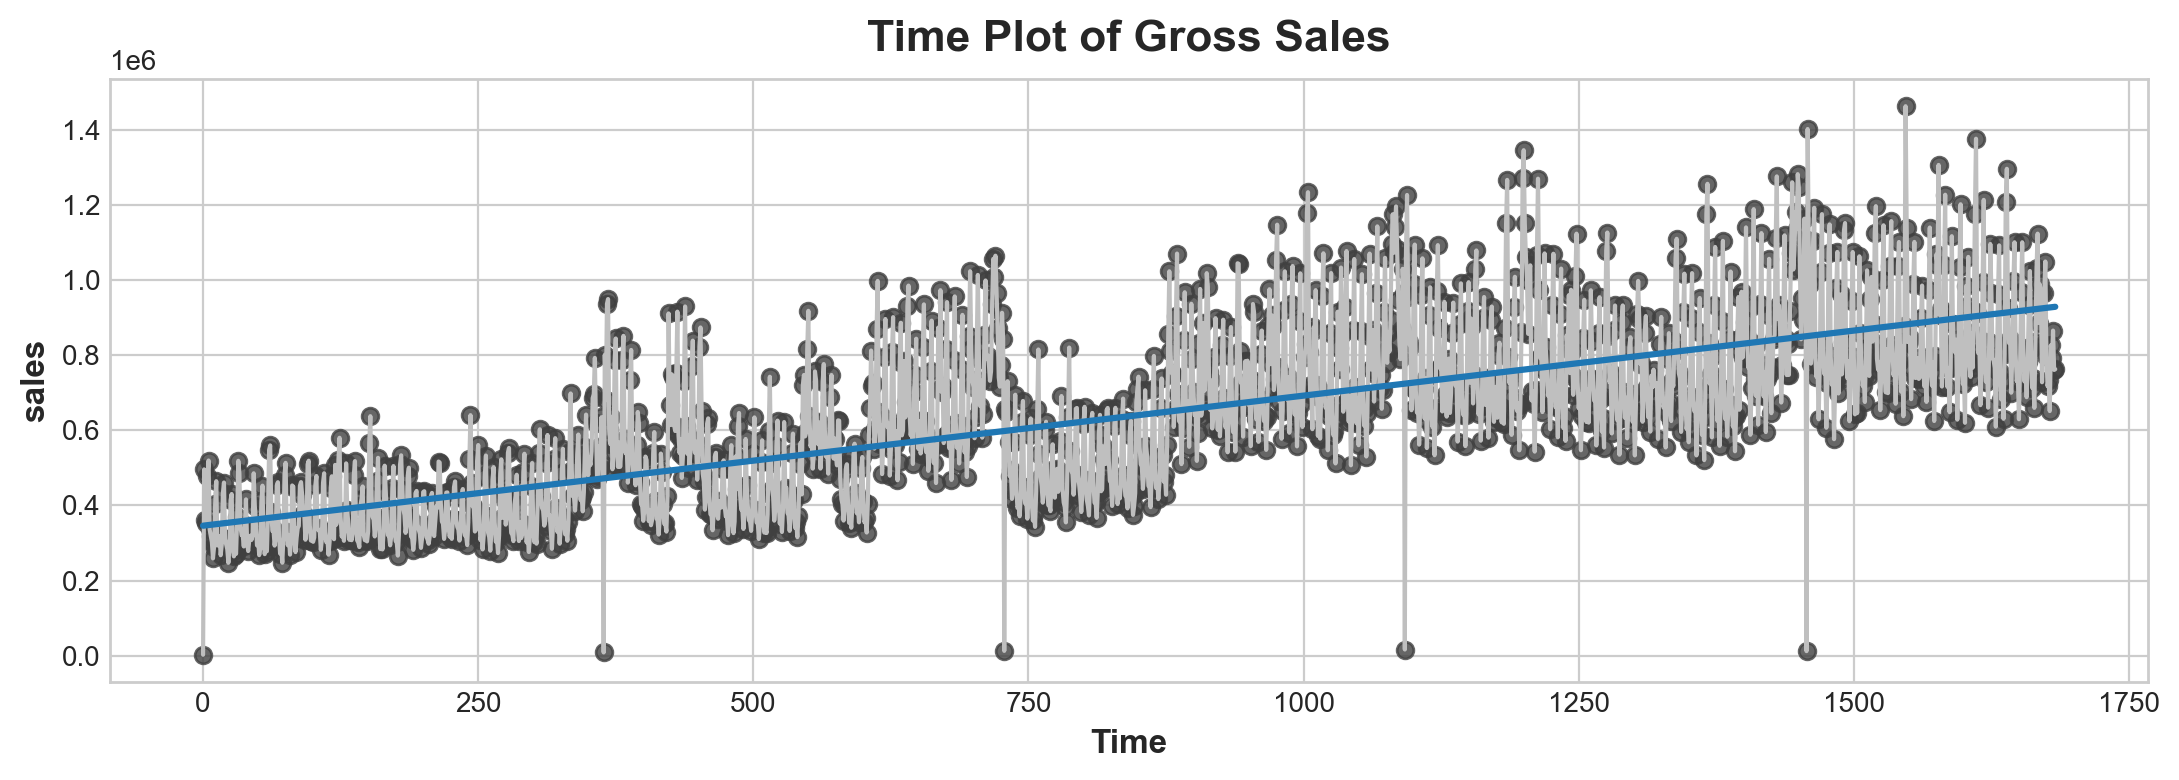

In [58]:
fig, ax = plt.subplots()
# scatter plot
ax.plot('Time', 'sales', data=gross_sale, color='0.75')
# regression plot
ax = sns.regplot(x='Time', y='sales', data=gross_sale, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Gross Sales');

Advantage of a timestep feature instead of just time is it scales verywell. So you don't have to worry too much about does it matter we measure in date units or in month units.

#### Lag Features
This one is about use previous value to predict future recent value

Text(0.5, 1.0, 'Lag Plot of Hardcover Sales')

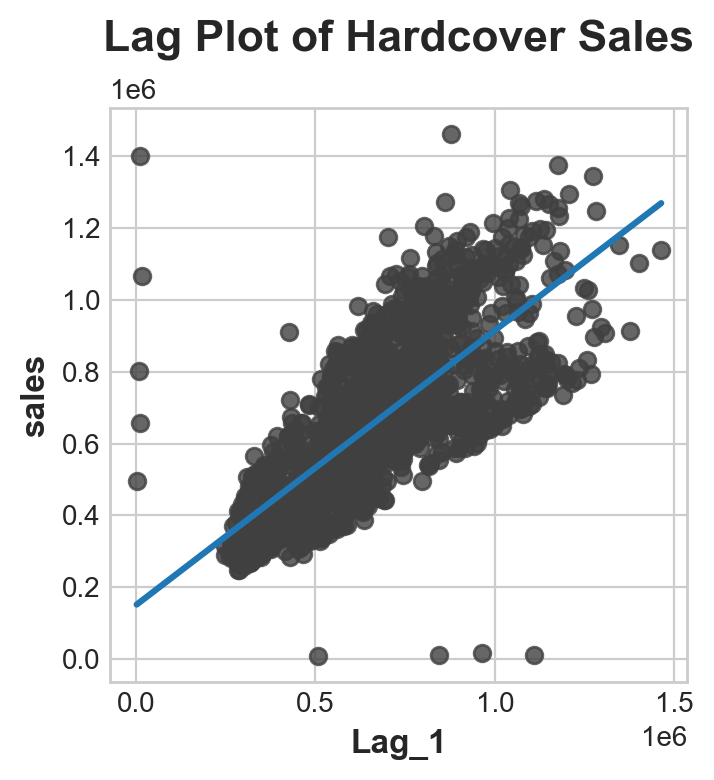

In [59]:
gross_sale['Lag_1'] = gross_sale['sales'].shift(1)
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='sales', data=gross_sale, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')

**serial dependence** high sales on one day usually means hig sales on the next day

In [60]:
X = gross_sale.loc[:, ['Time']]
y = gross_sale.loc[:, 'sales']
print('X looks like this: '), print(X.head(3)), print('...'), print(f"X is {type(X)}")
print('y looks like this: '), print(y.head(3)), print('...'), print(f"y is {type(y)}")
# HINT: do you know now why when fit X they prefer use the higher X

X looks like this: 
            Time
date            
2013-01-01     0
2013-01-02     1
2013-01-03     2
...
X is <class 'pandas.core.frame.DataFrame'>
y looks like this: 
date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
Name: sales, dtype: float64
...
y is <class 'pandas.core.series.Series'>


(None, None, None, None)

In [61]:
# fit a model be like:
X = gross_sale.loc[:, ['Time']]
y = gross_sale.loc[:, 'sales']
model = LinearRegression()
model.fit(X, y)
pred_y = pd.Series(model.predict(X), index = X.index)

#### Plus: Multi-assign and Plot several plot

In [62]:
# python hack about multi-assign
a, b = [1,2]
a, (b, c) = [1, (2, 3)]

### Trend

#### Data

In [63]:
df = pd.read_csv('data/store-sales-time-series-forecasting/train.csv',
                        index_col = 'date',
                        parse_dates = ['date']
                        ).to_period('D')
average_sales = df.groupby('date')['sales'].mean()

In [64]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Freq: D, Name: sales, dtype: float64

#### Moving Average 
Moving average is the idea of observe overage value within a window of time frame. But instead of those windows being mutually exclusive, those windows roll on.

In [65]:
len(average_sales.loc['2013'])

364

In the gross_sale data, one enclose cycle is one years. So window should be set as 360. minimum periods is typically half this window (not sure why)

<Axes: title={'center': 'Ploting Moving Average'}, xlabel='date'>

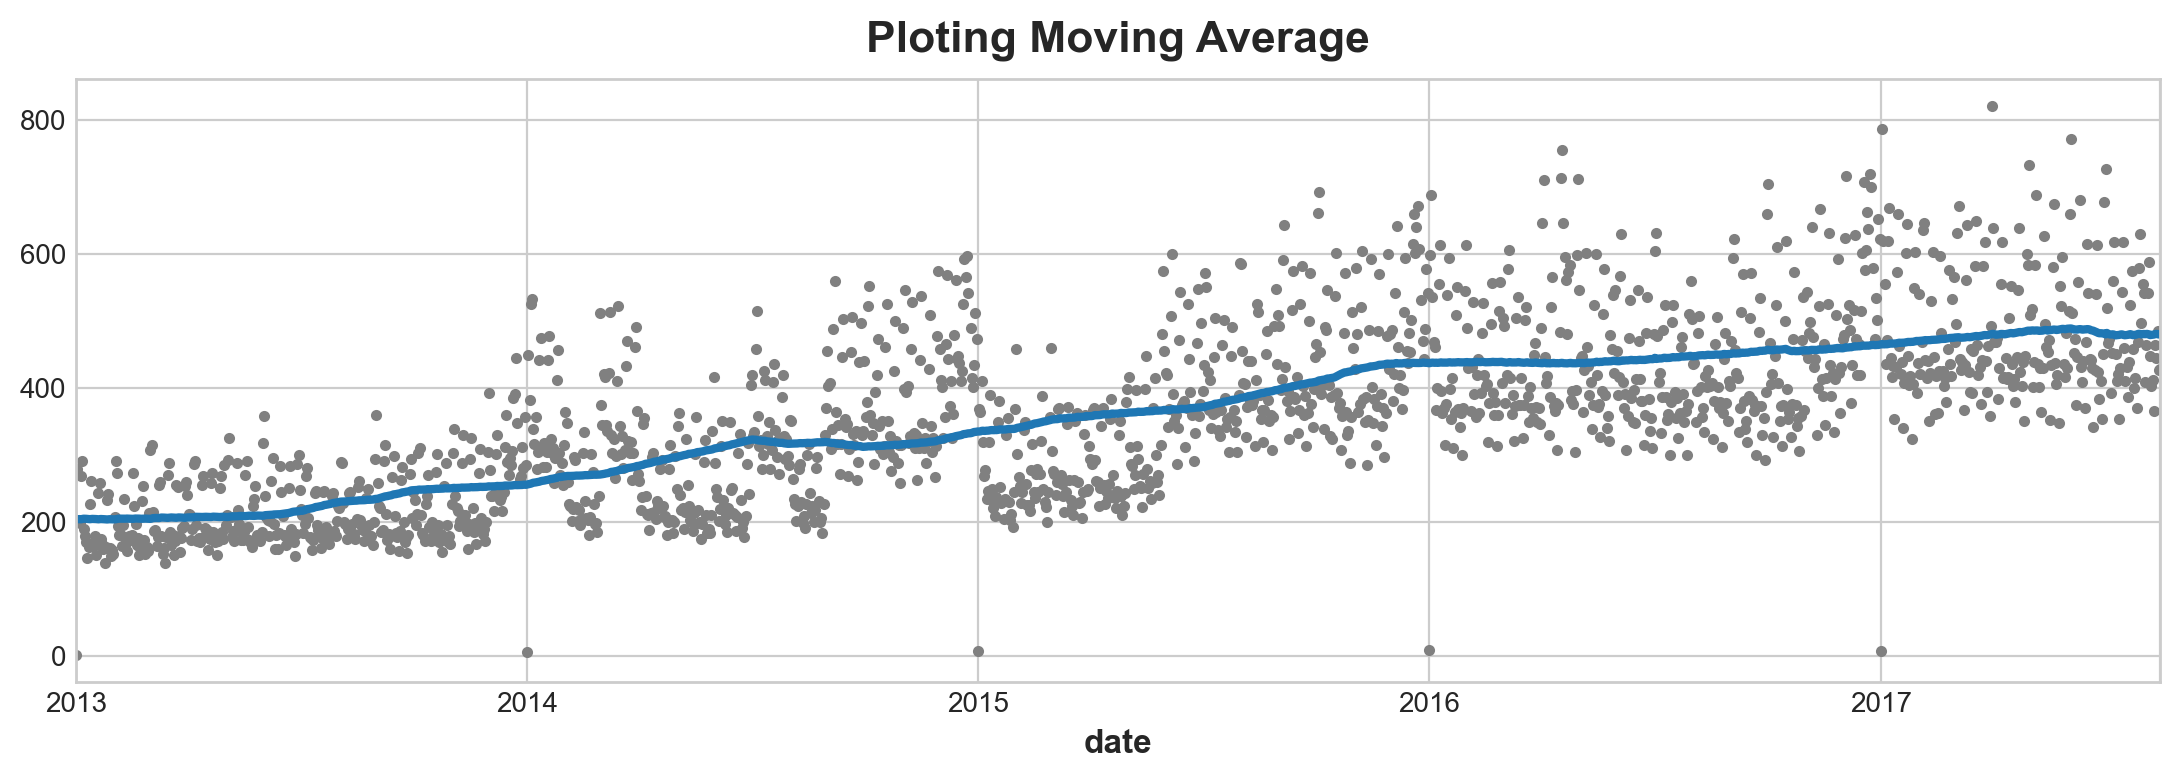

In [66]:
moving_average = average_sales.rolling(
    window = 364,
    center = True,
    min_periods=183
).mean()
ax = average_sales.plot(style = '.', color = '0.5')
moving_average.plot(
    ax = ax,
    linewidth = 3,
    title = 'Ploting Moving Average'
)

In [67]:
moving_average.sample(3), gross_sale.sample(3)

(date
 2015-12-20    437.490098
 2014-04-11    288.010483
 2015-12-17    436.879765
 Freq: D, Name: sales, dtype: float64,
                    sales  Time          Lag_1
 date                                         
 2016-05-25  6.375120e+05  1237  606377.205216
 2015-03-24  4.073697e+05   810  462664.237004
 2016-04-02  1.150825e+06  1184  872467.320075)


#### Deterministic Model 
which is a fancy term for linear regression with time series.
This is also a linear model. To make this model work requries you to converge time index `to_period` index. 

This process is similar to linear model. Instead fitting x, y, z three independ varaibles, you are fitting three x of different 'orders'.

$$
y = a + b\,x + c\,x^2 + d\,x^3 + ... + n\,x^{n}
$$

(Somewhat reminds me of Taylor's series. Maybe that's what order mans)
What's interesting about this function is odd quatric functions can vary ups and downs, so to fit into any shape you like.

In [68]:
#pip install statsmodels
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()
dp = DeterministicProcess(
    index=y.index,
    constant = True, # dummy features
    order = 3,       # time dummy trend, 1 is linear, 2 is quadratic, 3 cubic
    drop = True
)
X = dp.in_sample()
X.tail()

const   trend  trend_squared   trend_cubed
date                                                  
2017-08-11    1.0  1680.0      2822400.0  4.741632e+09
2017-08-12    1.0  1681.0      2825761.0  4.750104e+09
2017-08-13    1.0  1682.0      2829124.0  4.758587e+09
2017-08-14    1.0  1683.0      2832489.0  4.767079e+09
2017-08-15    1.0  1684.0      2835856.0  4.775582e+09

In [69]:
X_fore = dp.out_of_sample(steps = 90)
X_fore.head()

const   trend  trend_squared   trend_cubed
2017-08-16    1.0  1685.0      2839225.0  4.784094e+09
2017-08-17    1.0  1686.0      2842596.0  4.792617e+09
2017-08-18    1.0  1687.0      2845969.0  4.801150e+09
2017-08-19    1.0  1688.0      2849344.0  4.809693e+09
2017-08-20    1.0  1689.0      2852721.0  4.818246e+09

In [70]:
from sklearn.linear_model import LinearRegression
y = average_sales
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index = X.index)
y_fore = pd.Series(model.predict(X_fore), index = X_fore.index)

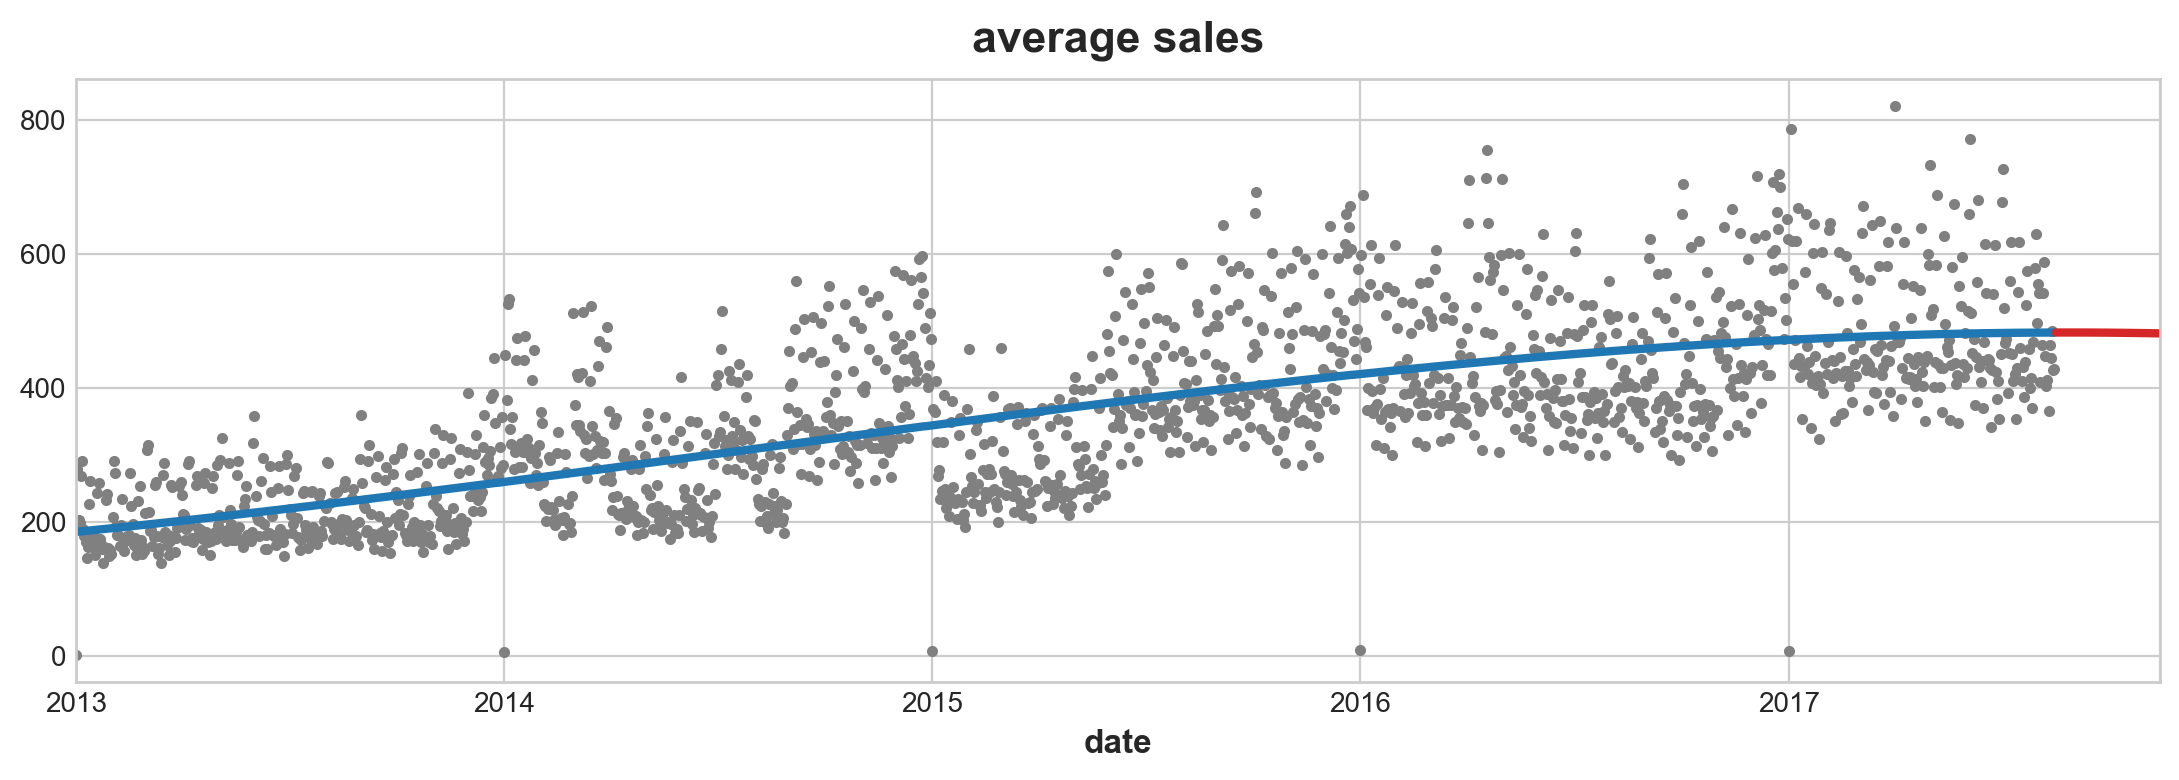

In [71]:
ax = average_sales.plot(
    style = '.', color = '0.5', title = 'average sales'
)
ax = y_pred.plot(ax= ax, linewidth=3, label='Trend') # underscore is for temporary variable
ax = y_fore.plot(ax = ax, linewidth=3, label="Trend Forcast", color = 'C3')

#### Risks of Highorder Ploynomials
Due to the property of function
> An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable.

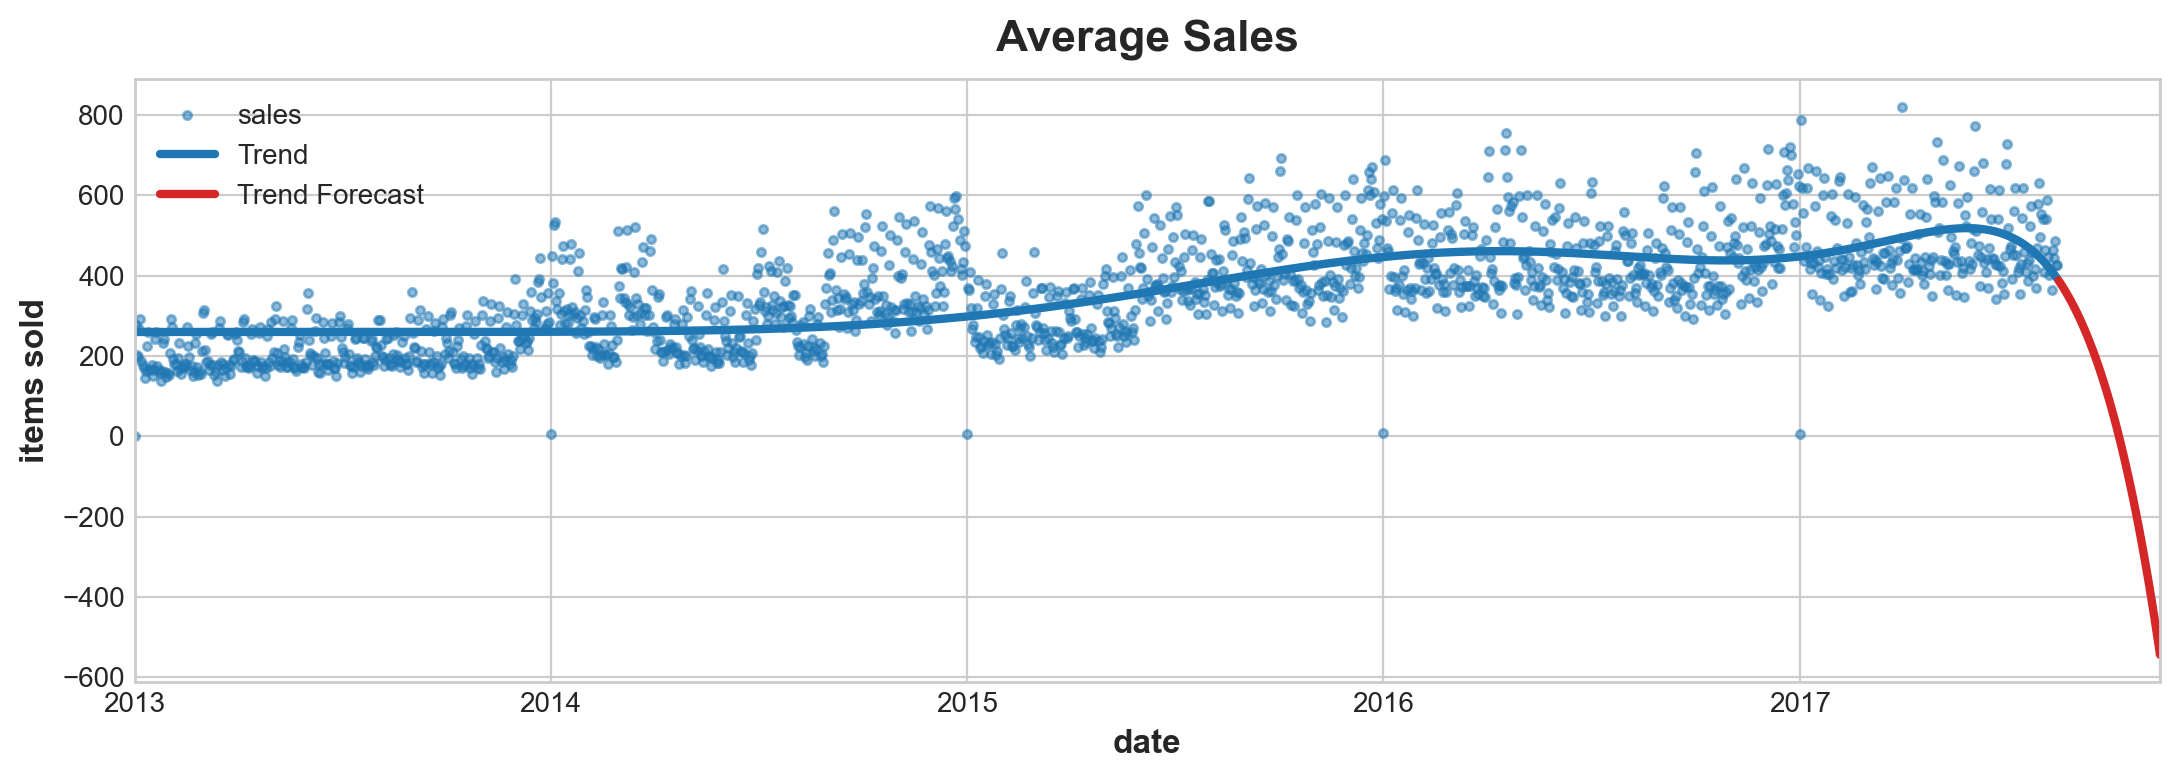

In [72]:
dp = DeterministicProcess(
    index=y.index,
    order = 11,       # time dummy trend, 1 is linear, 2 is quadratic, 3 cubic
)
X = dp.in_sample()

model = LinearRegression(fit_intercept = True)
model.fit(X, y)

X_fore = dp.out_of_sample(steps=90)
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index = X_fore.index)

ax = y.plot(style = '.', alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

#### Fit Trend with Spines
Multivariate Adaptive Regression Splines (MARS)
> Splines are a nice alternative to polynomials when you want to fit a trend. The Multivariate Adaptive Regression Splines (MARS) algorithm in the pyearth library is powerful and easy to use. There are a lot of hyperparameters you may want to investigate.

This use `Earth()` model in pyearth package 
by Stephen Milborrow, the originsl is R version. [API here](https://contrib.scikit-learn.org/py-earth/index.html#)
You will need to install via conda. Use the one under scikit-learn. 

~~conda install~~
`pip install sklearn-contrib-py-earth`

In [73]:
#from pyearth import Earth
try: 
    y = average_sales.copy()
    dp = DeterministicProcess(index=y.index, order=1)
    X = dp.in_sample()

    # Fit a MARS model with `Earth`

    model = Earth()
    model.fit(X, y)

    y_pred = pd.Series(model.predict(X), index=X.index)

    ax = y.plot(#**plot_params, 
                title="Average Sales", ylabel="items sold")
    ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
except: 
    print('This code will no execute until pyearth is installed')

This code will no execute until pyearth is installed


### Seasonality
You already know sine and cosine functions are used to model these. 
Terms are called **Fourtier features**.

#### Fourier Features
1 pair of fourier features are:
$$
k =  2 \pi \frac{t}{f}
\\
f(j) = \beta_1 \sin(j * k) + \beta_2 \cos(j * k)
$$

$n$ order(s) of fourier features:
$$
 F(n) = \sum_{j=1}^{n} f(j)
 $$

* $k$ is time scaled to frequency
* $i$ is order of features
* $\beta_1$ and $\beta_2$ is what you throw into linear regression

The advantage of a fourier pair is so that two parameters are at the same scale. 



In [74]:
# create fourier feature for linear regression to figure out
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
# this transform it into something you are easy to fits into linear regression

#### Periodogram
Given frequency y =
$ \frac{\beta_1 ^2 + \beta_2 ^ 2} {2}$ $\beta_1$, $\beta_2$ is the coefficients of sine and cosine.

A useful trigonometric identity is is:
$$
A \cos(2 \pi \omega t + \phi) = \beta_1 \cos(2 \pi \omega t) + \beta_2 \sin(2 \pi \omega t) \\
\beta_1 = A \cos(\phi) \\
\beta_2 = - A \sin(\phi) \\
2A^2 = \beta_1^2 + \beta_2^2
$$
The whole time series is represented as:
$$
x_t = \sum_{j = 1}^{n/2} 
      [
        \beta_1(\frac{j}{n}) cos(2 \pi \omega_j t)+ 
        \beta_2(\frac{j}{n}) sin(2 \pi \omega_j t)
      ]
$$
In periodogram given $\frac{j} {n}$ frequency:
$$
P(\frac{j} {n}) = \beta_1^2 (\frac{j} {n}) + \beta_2^2(\frac{j}{n})
$$

> A relatively large value of P(j/n) indicates relatively more importance for the frequency j/n (or near j/n) in explaining the oscillation in the observed series. P(j/n) is proportional to the squared correlation between the observed series and a cosine wave with frequency j/n. The dominant frequencies might be used to fit cosine (or sine) waves to the data, or might be used simply to describe the important periodicities in the series.

[source: PennState Eberly College of Science](https://online.stat.psu.edu/stat510/lesson/6/6.1)

* Estimate $\beta_1$ and $\beta_2$ is two of n parameters
* They are not neccessary estimated by regression but this math device called Fast Fourier Transformation (FFT)



#### (Fast) Fourier Transformation
![image](image/FFT-Time-Frequency-View-540.png)


I think of it this way. Think you can fit a n sum of fontier pairs together. Your frequency is then coposed of n possible pair of fourier pairs. The higher order, the higher the freqency (lower the wave length). Some fourier will be more dominant than the other. When a fourier pair is not dominant, their sum of $\beta$ square may as well be 0. This means it cancels them out. So if you slice the equation by fourier pairs. Each pair will represent strenght of that wave function. With 0 indicate very low effect. Higher value indicate more dominate effect.

[dig further: what is fourier transform](https://mriquestions.com/fourier-transform-ft.html)

##### Custom Functions

In [75]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram( # this code do not generate graph it creates two vectors
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

##### Example

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

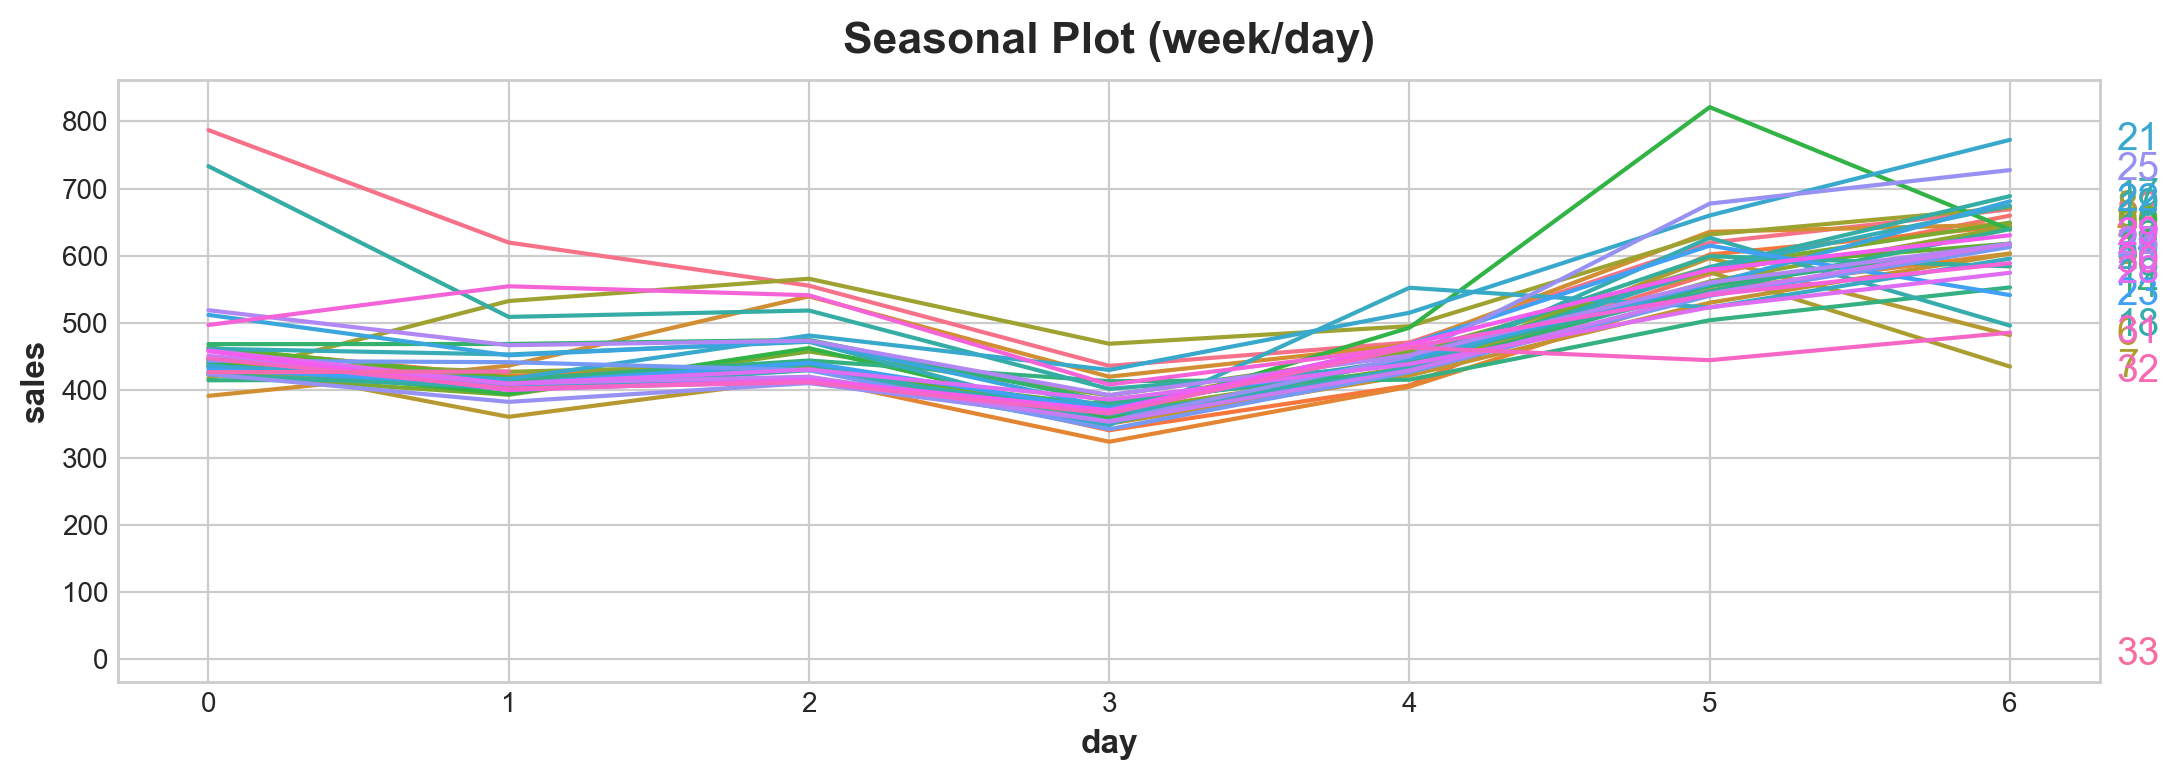

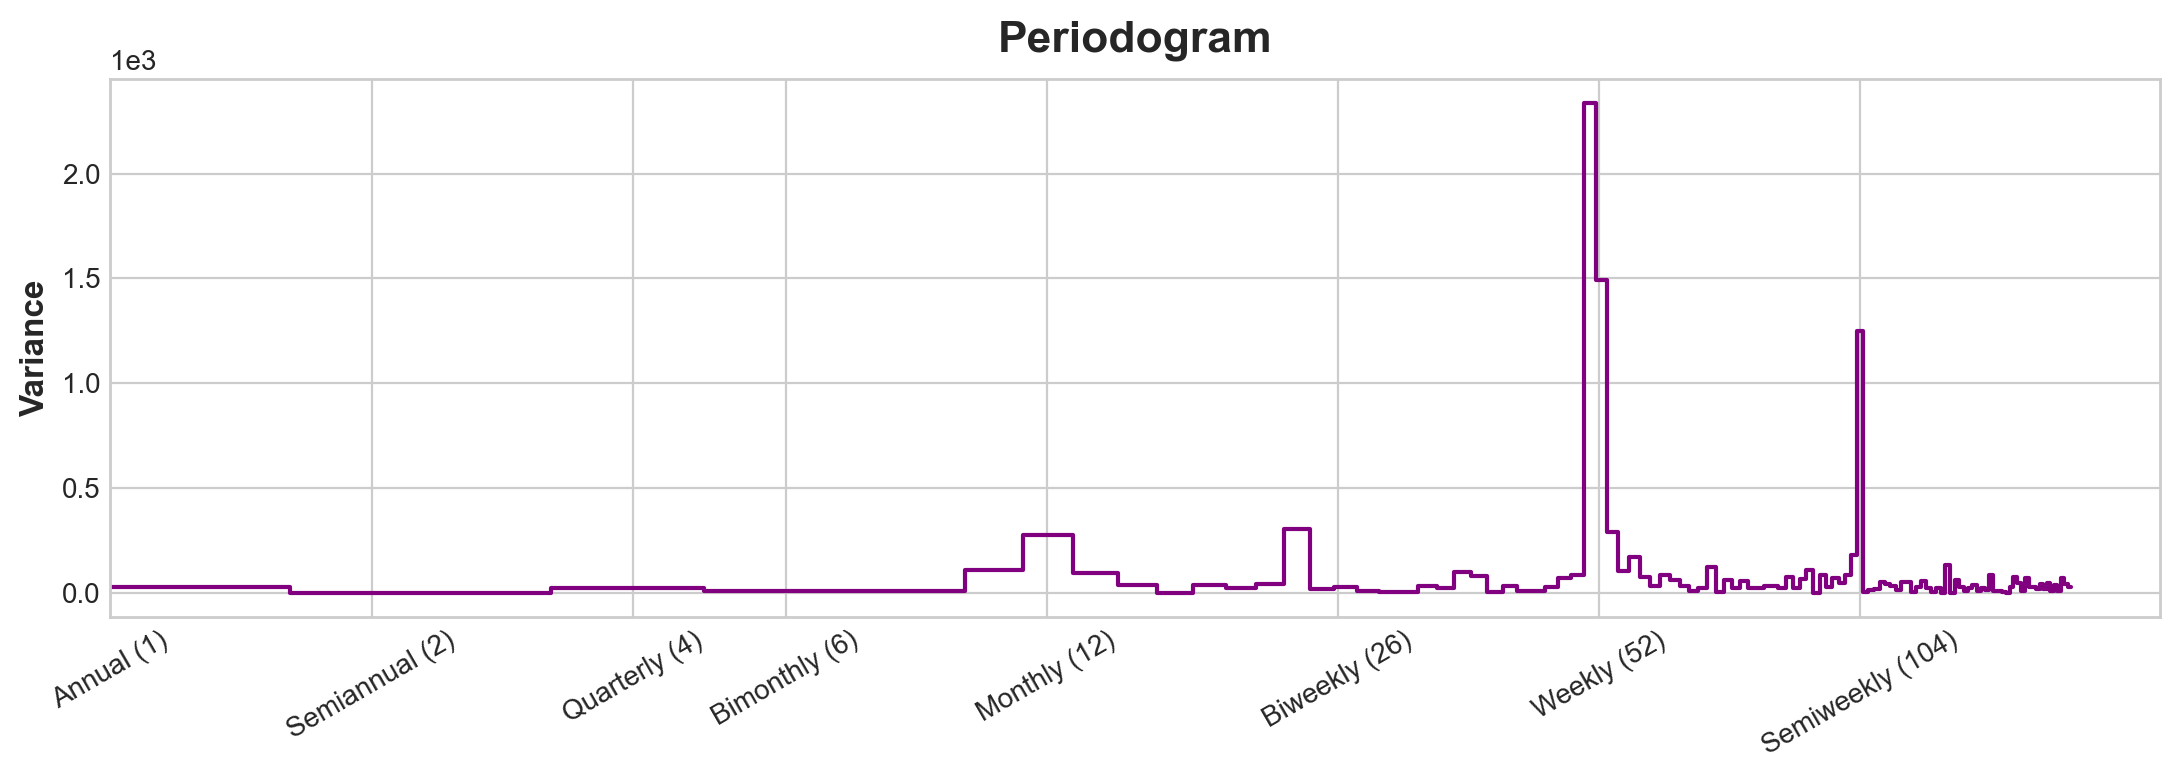

In [76]:
average_sales_2017 = average_sales.squeeze().loc['2017']
X = average_sales_2017.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, 
              'sales',
              period = 'week',
              freq = 'day')
plot_periodogram(average_sales_2017)

NOTE: **This set of features happens to have four spikes** and **the four spkes happens to be consecutive**

Note x is completely different scale to what's introduce in PenState's text book (where frequency is represented as a fraction). Here frequency is represented as the inverse whole period with low frequency left and high frequency right.

This graph tells you strong weekly seasonality. Because you want to reduce chances of over fitting. You want to try reduce the fourier sets. You can model these ways: 

- 12 month frequency (30/365) with 4 fourier pairs 
- 1 anual frequency (364/365) with 26 fourier paris (there will be a lot of frequency here)

Set frequency as how you want period to return. As order increase it captures the intrinsic orders of the frequency. 

So in the one the first fourier feature is observed monthly hense the set frequency to month. There are about four additionaly waves (they all happens to be twice as frequent as the other one). Hense we set four fourier pairs.

### Compute Fourier Feature (`statmodels`)

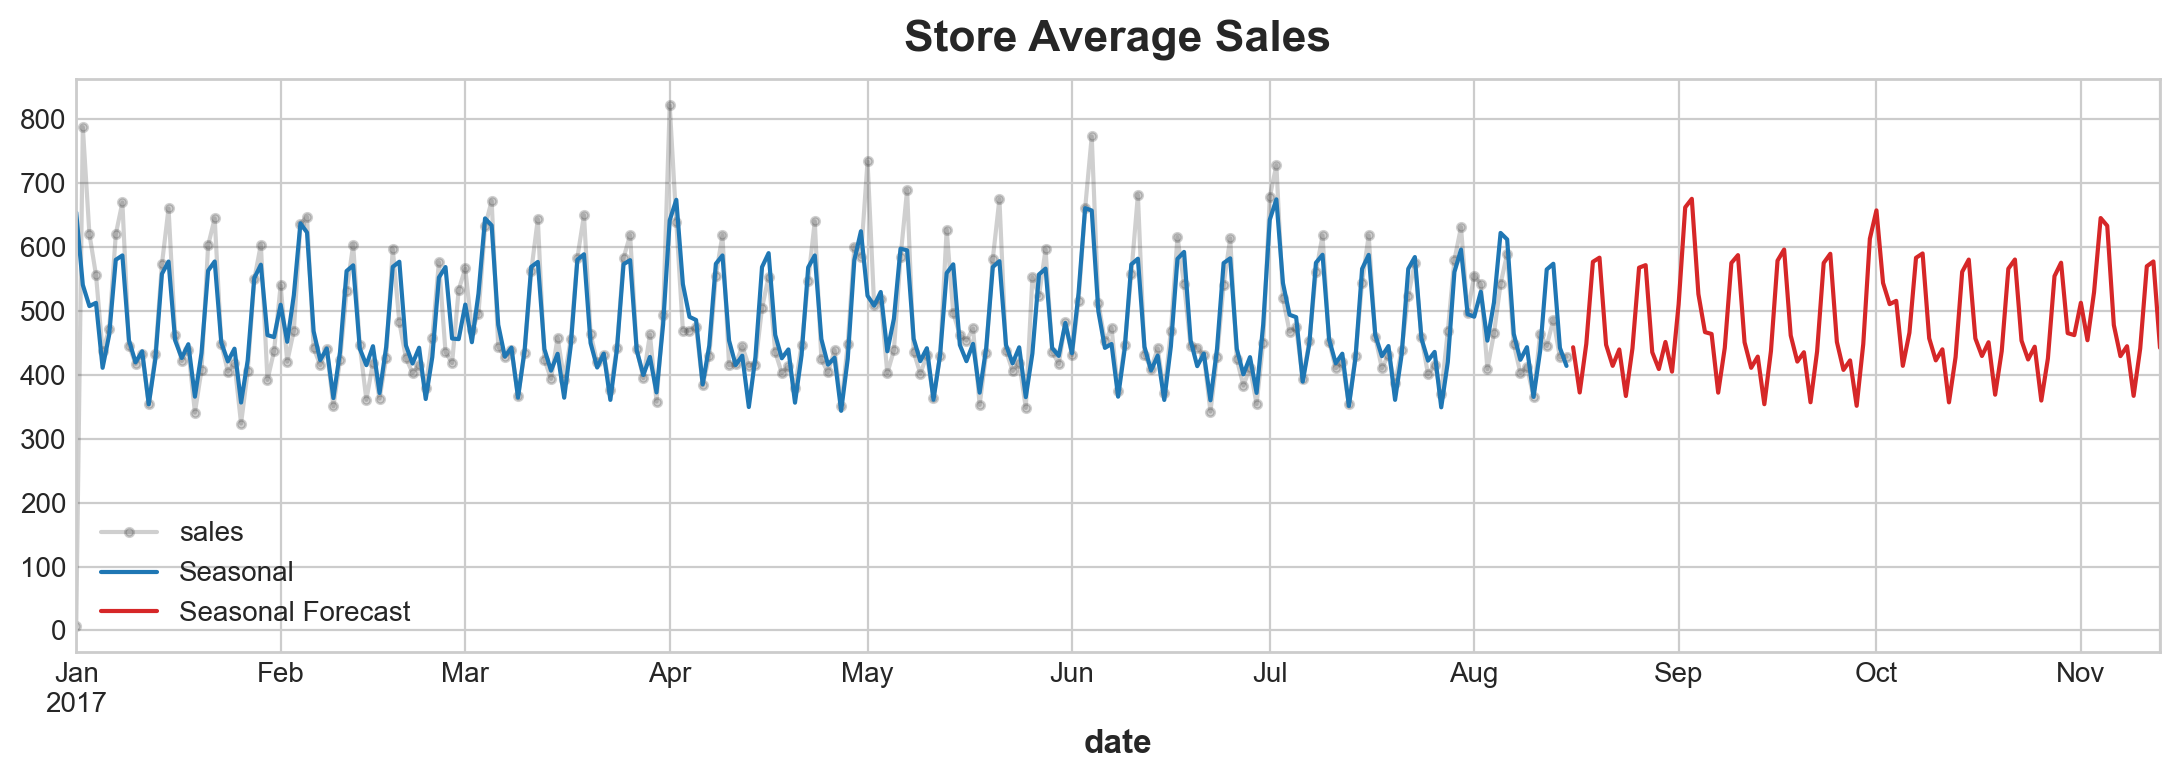

In [77]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
fourier = CalendarFourier(freq="M", order=4) # here parameter derived from periodogram
dp = DeterministicProcess(
    index=average_sales_2017.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
X = dp.in_sample()  
# note fourier needs to be made as a list for it to be literatable
y = average_sales_2017
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
ax = y.plot(color='0.25', style='.-', alpha = 0.25,title="Store Average Sales")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend();

In [78]:
#X.to_csv('data/output/Calenrier_output.csv')

### Detrend or deseasonalising
Verify that we are not modeling random variance 

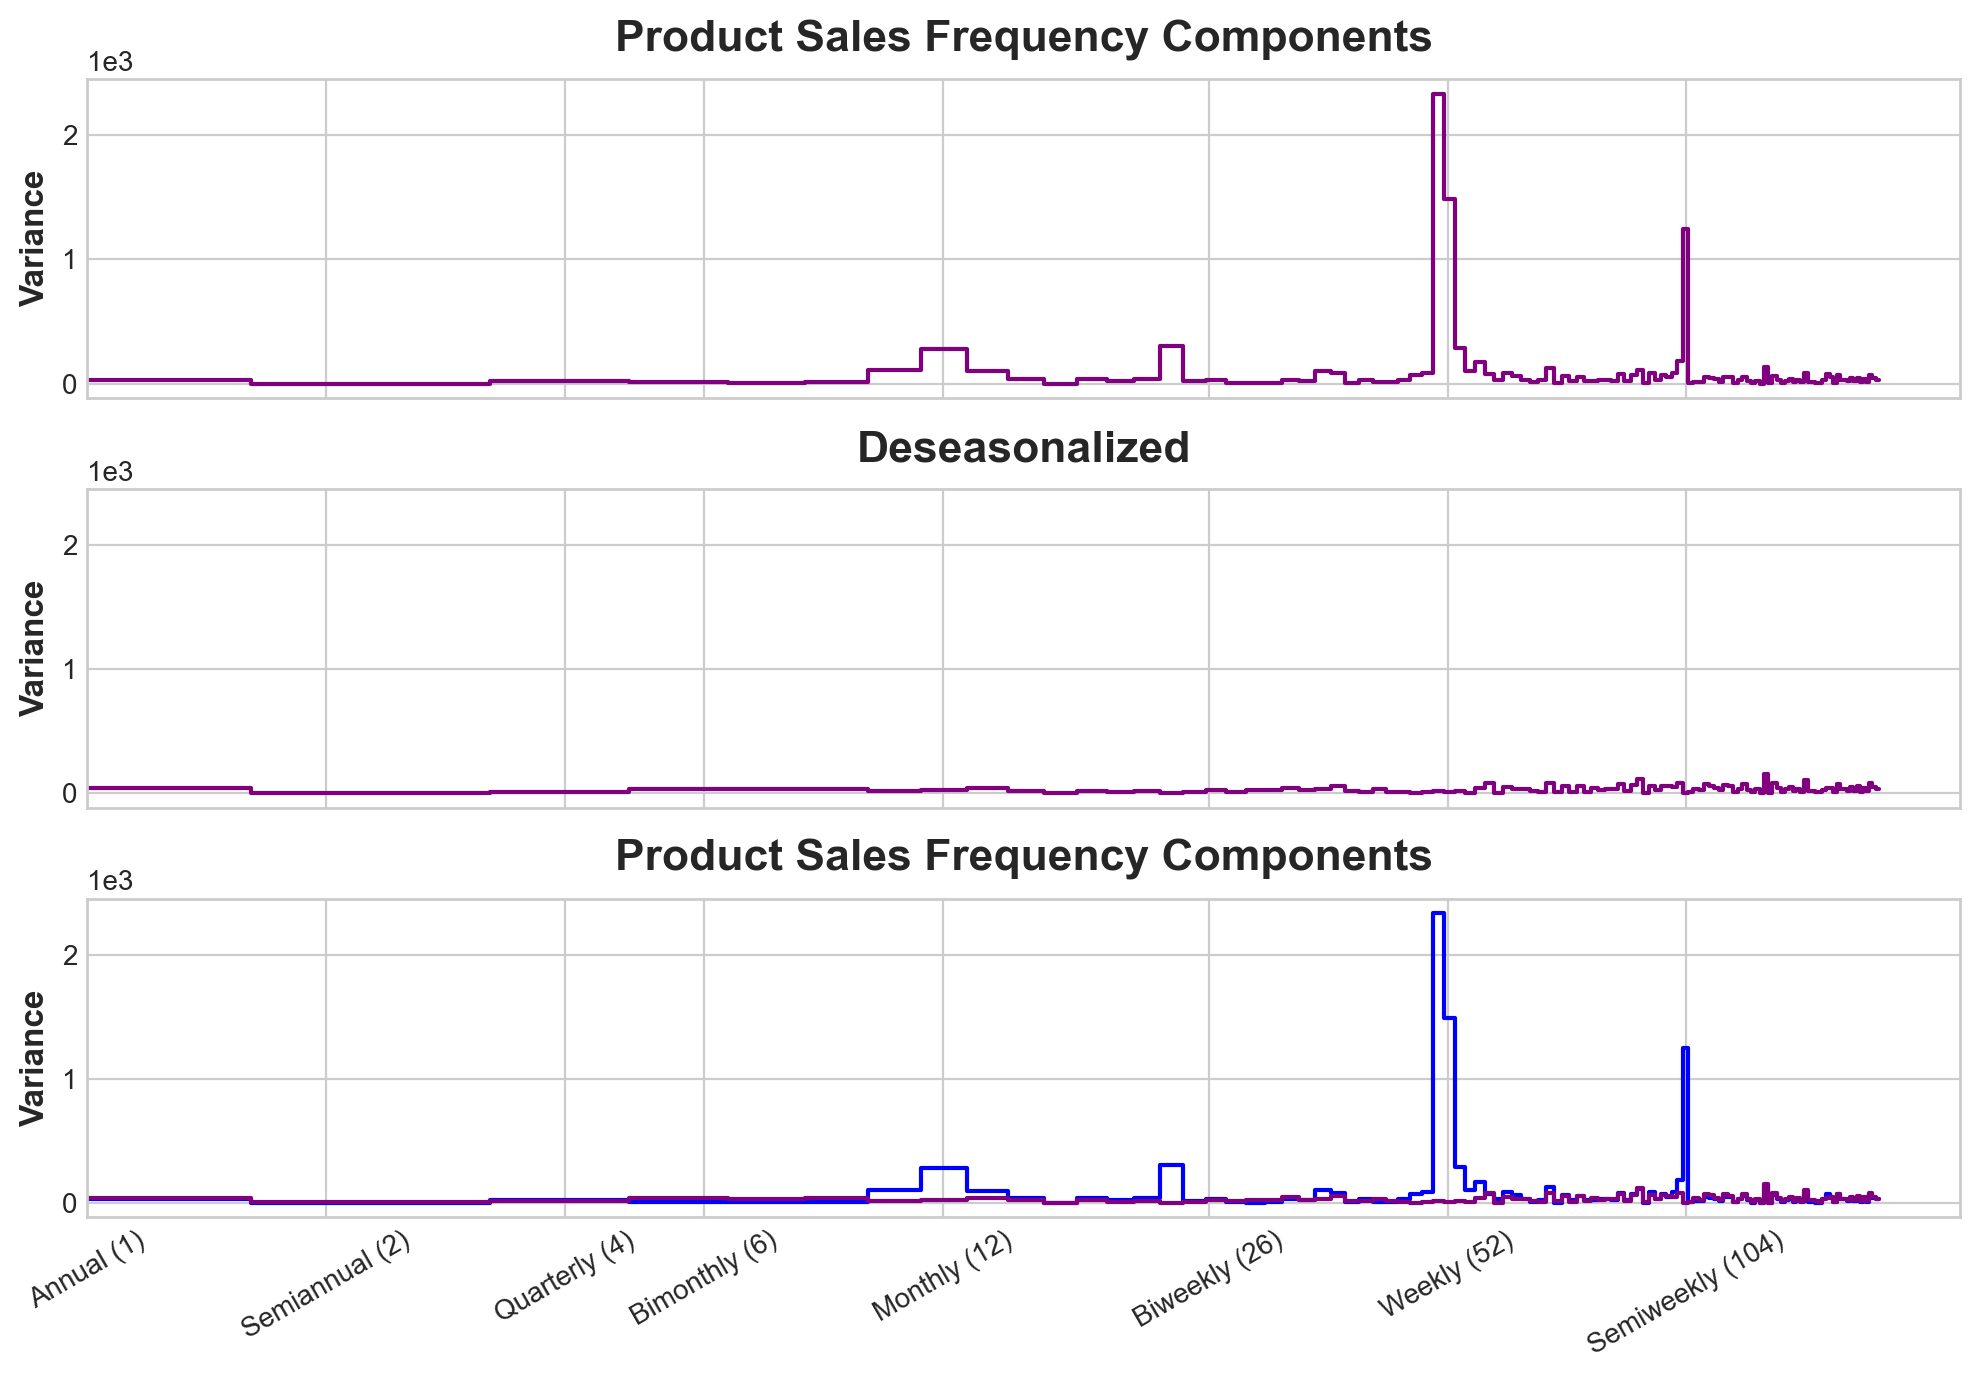

In [79]:
y_deseason = y - y_pred

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")
ax3 = plot_periodogram(y, ax=ax3)
#ax.axes.set_facecolor('blue')
ax3 = plot_periodogram(y_deseason, ax=ax3)
ax3.axes.lines[0].set_color('blue')
ax3.set_title("Product Sales Frequency Components"); # take this out you would be creating a new plot

This plot shows that our model ahs surverred very well in explaining seasonality variance.

#### Holiday (Special Events)
You can fit spacial events by creating dummy variables (here it is convinent because we are only useing one years to train)

In [80]:
holidays_events = pd.read_csv(
    'data/store-sales-time-series-forecasting/holidays_events.csv',
    index_col = 'date',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates = ['date'],
    infer_datetime_format=True
    ).to_period('D')
#type(holidays_events.index)
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

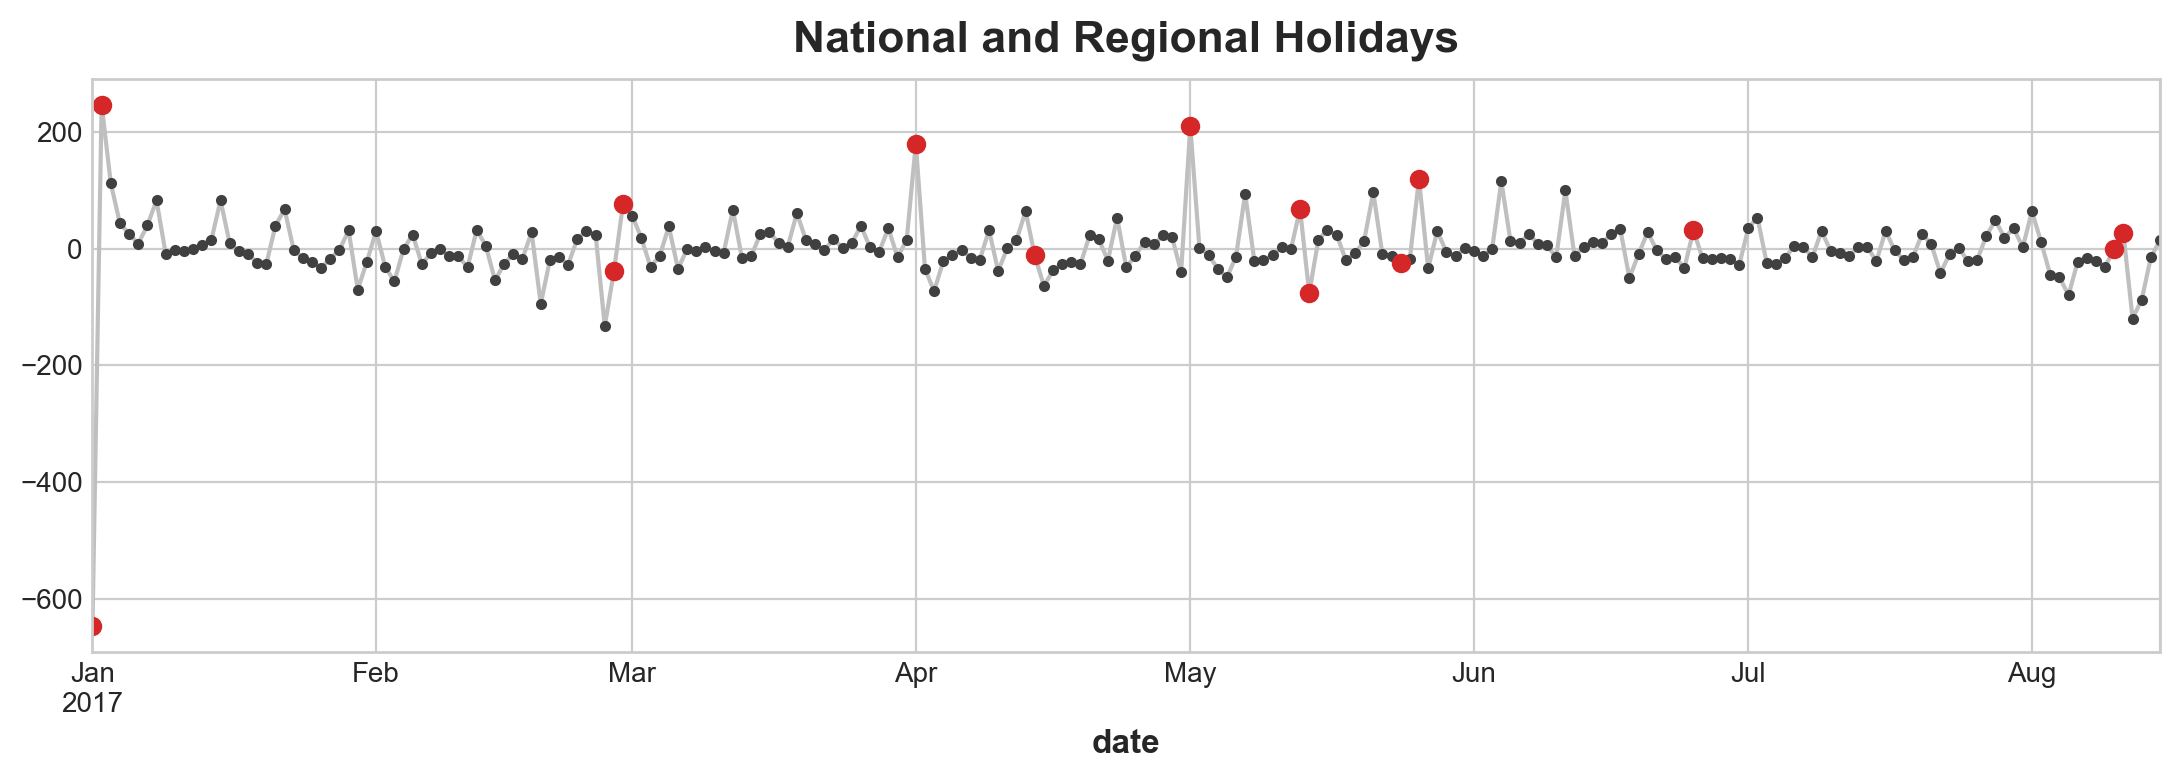

In [81]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [82]:
X_holidays = pd.get_dummies(
    holidays,
    columns = ['description']
)
X2 = X.join(X_holidays, on='date').fillna(0.0)
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index = X2.index,
    name = 'Fitted',
)

In [84]:
X_holidays.sample(3)

description_Batalla de Pichincha  description_Carnaval  \
date                                                                 
2017-01-01                                 0                     0   
2017-08-10                                 0                     0   
2017-08-11                                 0                     0   

            description_Dia de la Madre  description_Dia de la Madre-1  \
date                                                                     
2017-01-01                            0                              0   
2017-08-10                            0                              0   
2017-08-11                            0                              0   

            description_Dia del Trabajo  \
date                                      
2017-01-01                            0   
2017-08-10                            0   
2017-08-11                            0   

            description_Primer Grito de Independencia  \
date                                                    
2017-01-01                                          0   
2017-08-10                                          1   
2017-08-11                                          0   

            description_Primer dia del ano  \
date                                         
2017-01-01                               1   
2017-08-10                               0   
2017-08-11                               0   

            description_Provincializacion de Cotopaxi  \
date                                                    
2017-01-01                                          0   
2017-08-10                                          0   
2017-08-11                                          0   

            description_Provincializacion de Imbabura  \
date                                                    
2017-01-01                                          0   
2017-08-10                                          0   
2017-08-11                                          0   

            description_Traslado Batalla de Pichincha  \
date                                                    
2017-01-01                                          0   
2017-08-10                                          0   
2017-08-11                                          0   

            description_Traslado Primer Grito de Independencia  \
date                                                             
2017-01-01                                                  0    
2017-08-10                                                  0    
2017-08-11                                                  1    

            description_Traslado Primer dia del ano  description_Viernes Santo  
date                                                                            
2017-01-01                                        0                          0  
2017-08-10                                        0                          0  
2017-08-11                                        0                          0

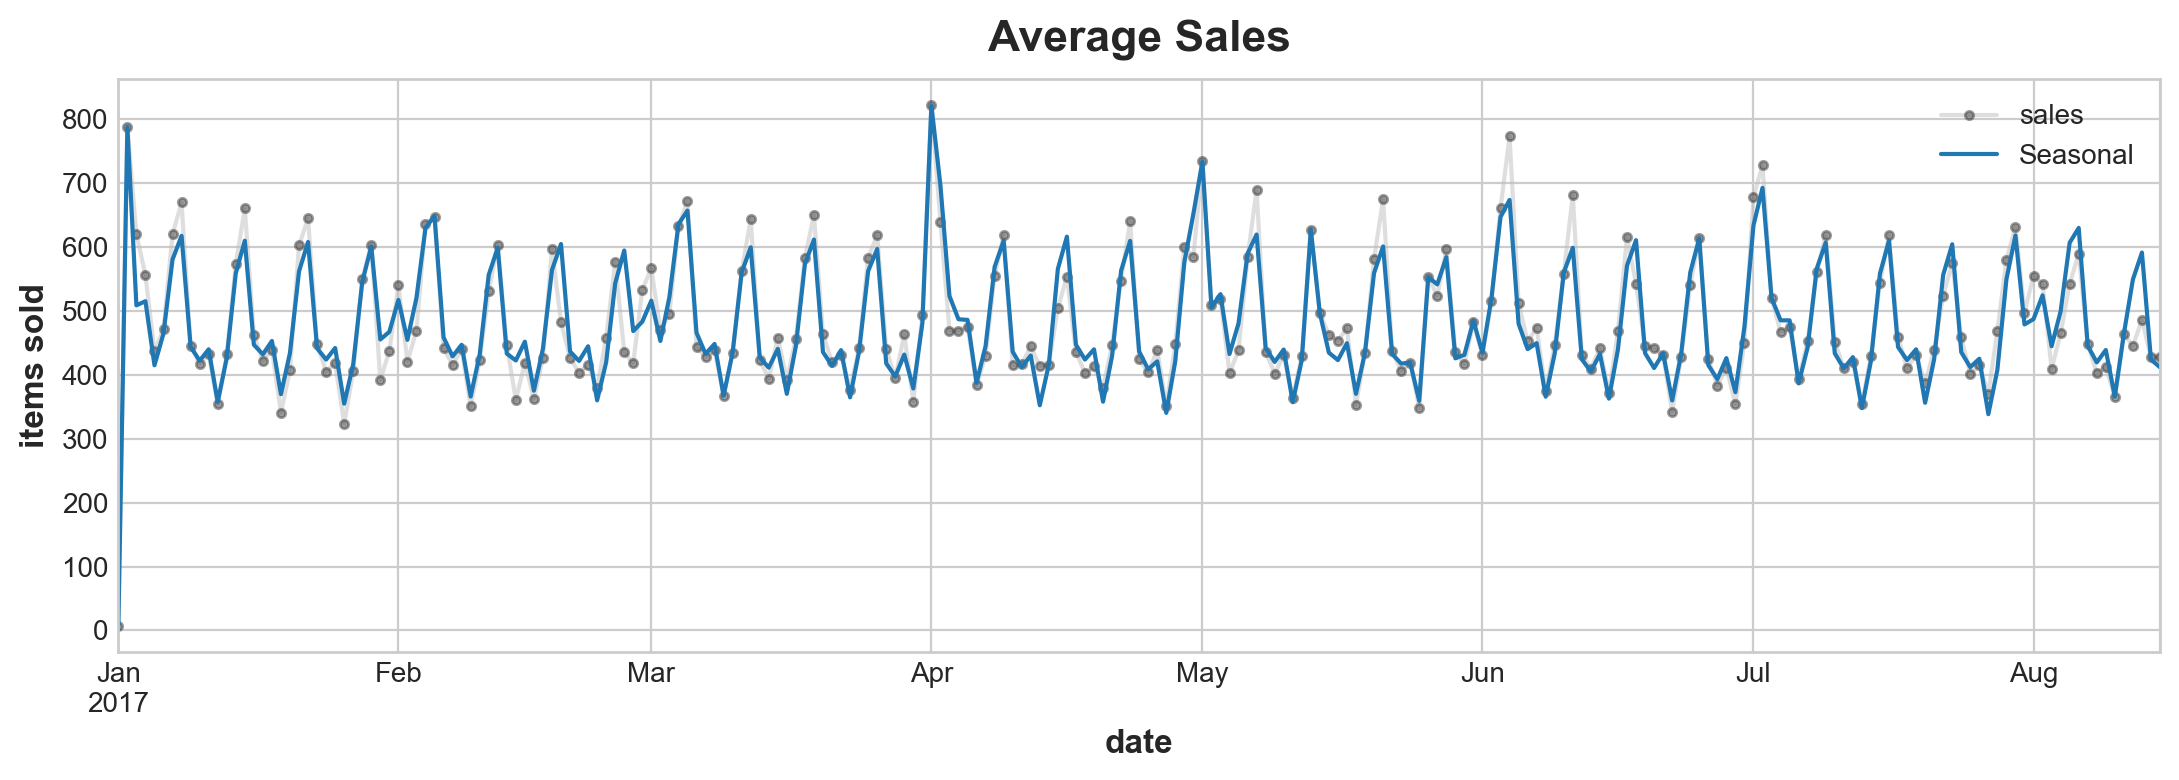

In [30]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

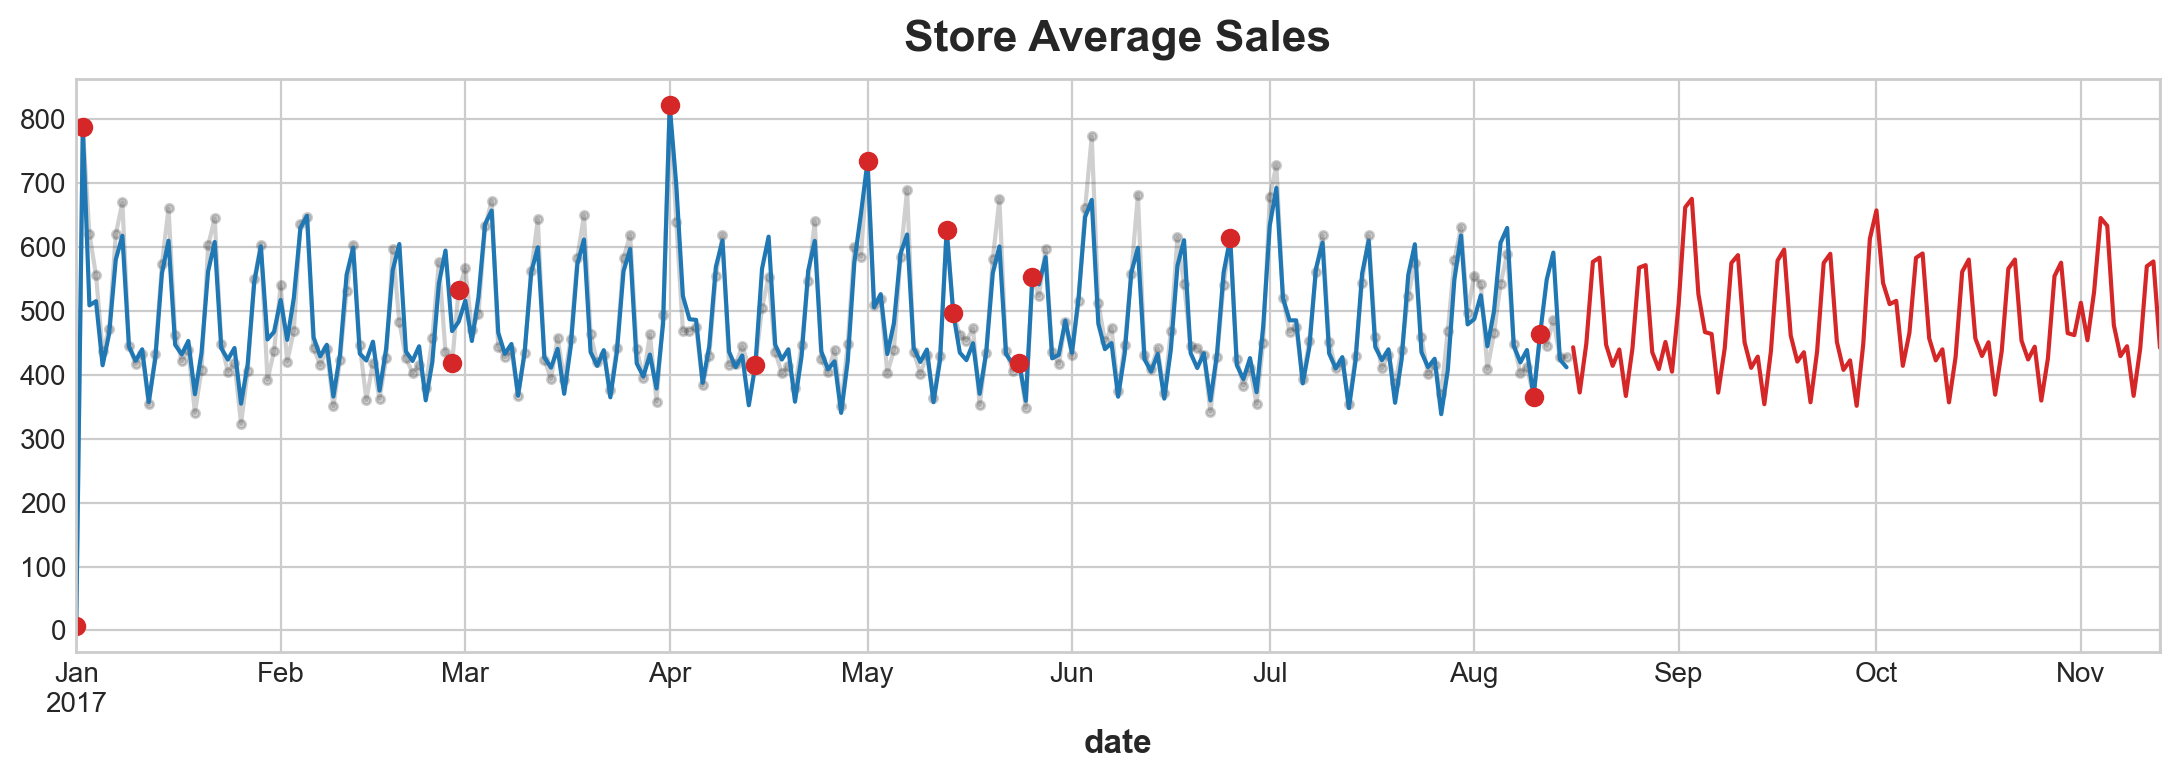

In [31]:
ax = y.plot(color='0.25', style='.-', alpha = 0.25,title="Store Average Sales")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax = plt.plot_date(holidays.index, y[holidays.index], color = 'C3');

### Time Series as Features

#### Partial Autocorrelcation

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


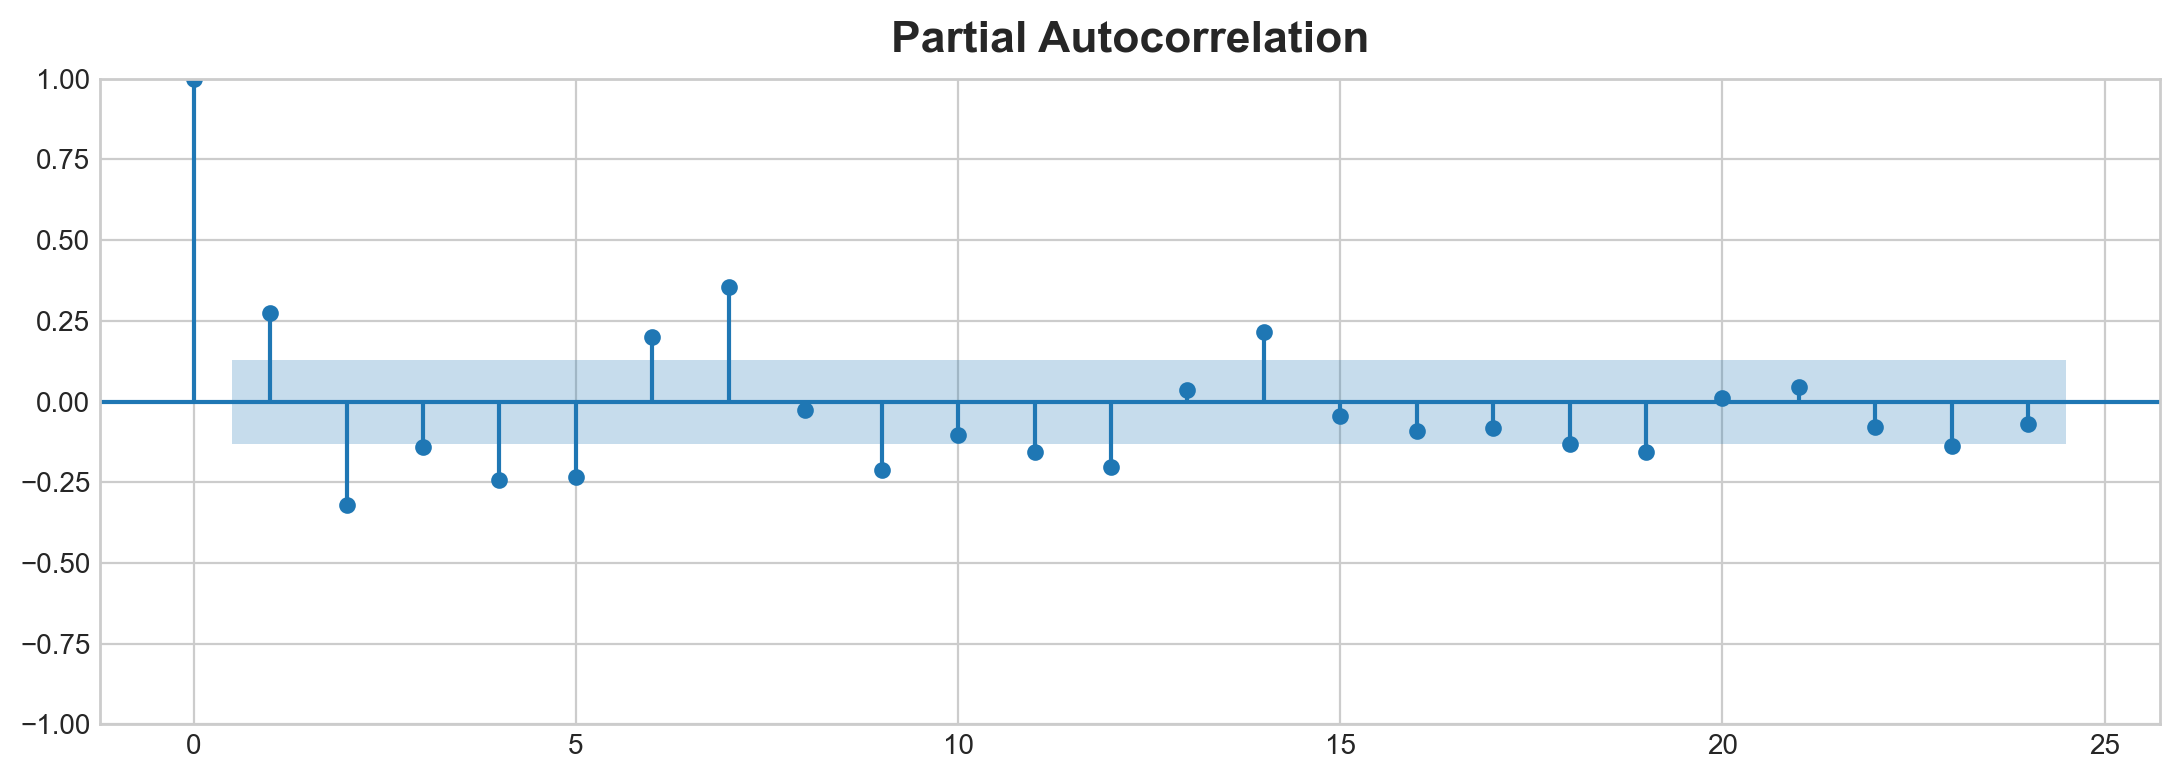

In [33]:
plot_pacf(average_sales_2017);

### Cycle


### Hybrid Models

Essentially all above combined: 

series = trend + seasons + cycles + error

Regression algorithmn:
* transform target:
	* for example **decision tree**. 
	* **group target value** in training and make prediction of feature by averaging values in a group
* transform features:
	* for example polynormial function. Use mathmatical function. 
	* featues as input combines and transform

Feature Transformer **Extrapolate Target Value** (think of this as a point inbetween two discrete value amongst a function) beyound **bondary** of training set.
Same cannot be said for **Decision Tree**. Random Forest and Gradient boosted decision tree takes the last step.

#kaggle recommend: 
1. linear regression for extrapolate trend 
2. transform target to remove trend
3. apply [XGBoost](https://xgboost.readthedocs.io/en/stable/) to detrended residual


#### linbear regression + XGBosst

In [34]:
from pathlib import Path
from warnings import simplefilter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("data/ts-course/")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1) # this is a hayer of hierarachical index

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

Tips: now retail is hierarchically indexed you can only have to access a top layer column before you can access a bottom layer.

In [35]:
y = retail.copy()
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True
)
X = dp.in_sample() # features for training data

idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index, # index are index
    columns=y_train.columns, # columns are column labels
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

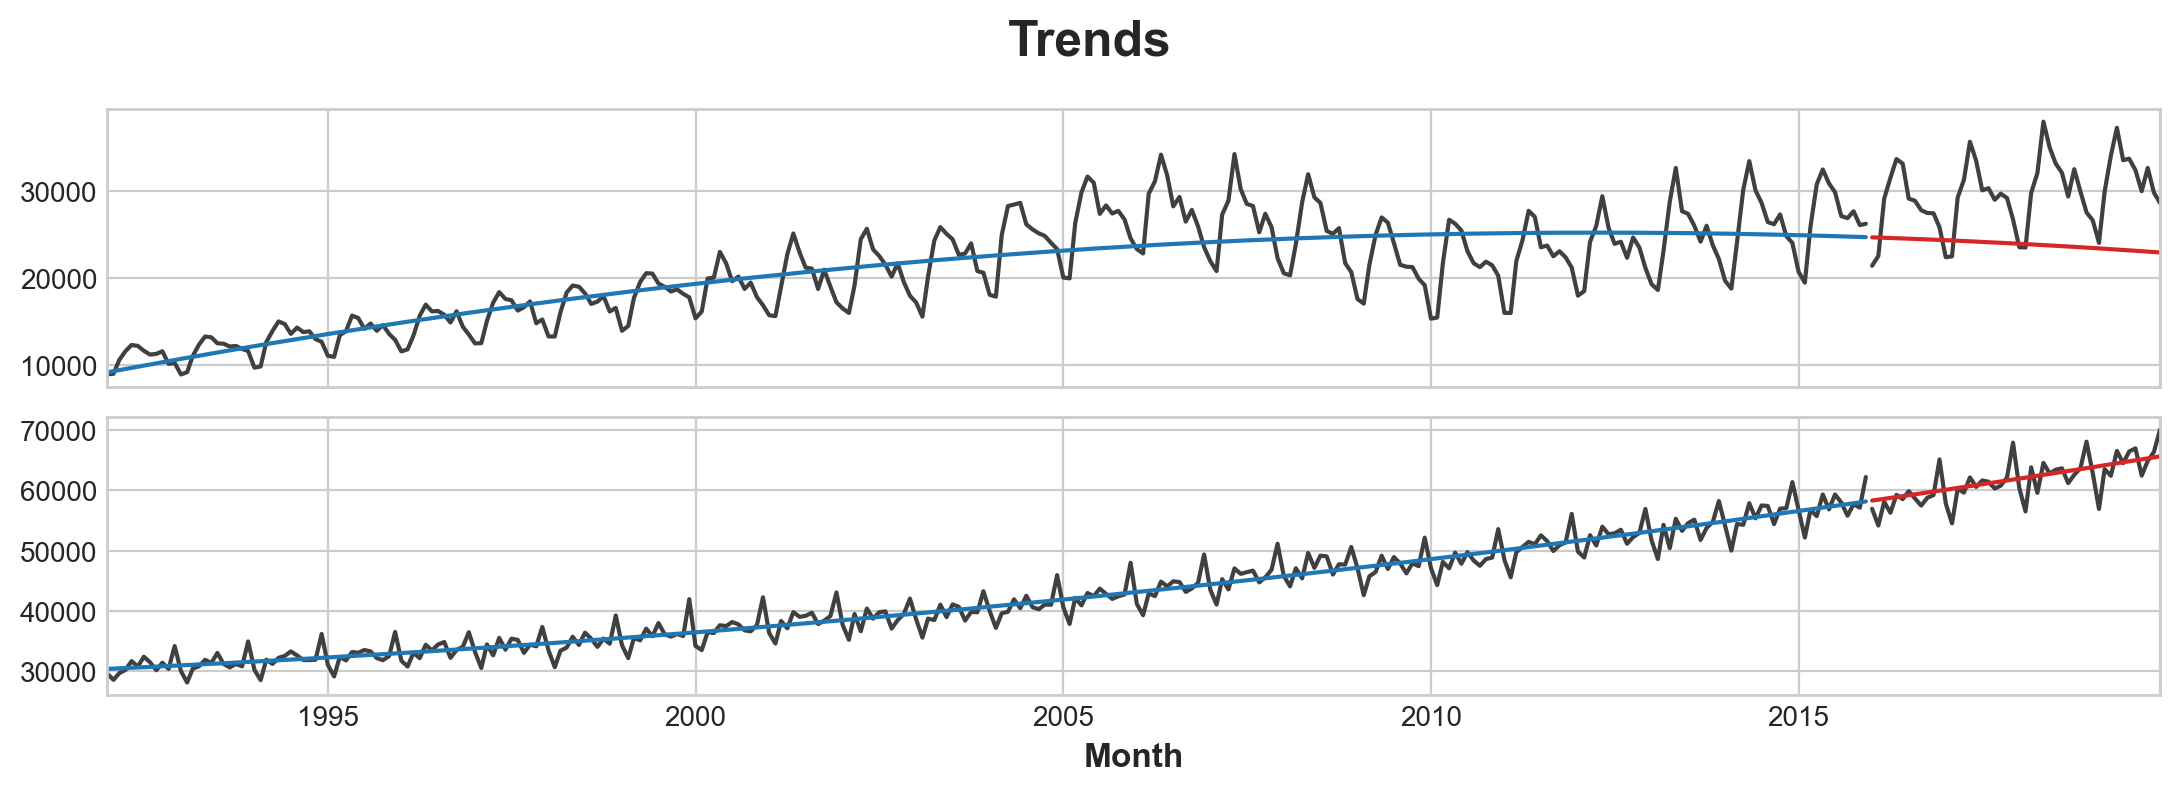

In [36]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Data Transformation before add XGBOOST

> While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from wide format, with one time series per column, to long format, with series indexed by categories along rows.

In [37]:
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [38]:
print("stack transform default retaill index \n from {var1} \n to {var2} \
      ( y index)".format(
var1 =type(retail.head().index),
var2 =type(y.head().index)
))

stack transform default retaill index 
 from <class 'pandas.core.indexes.period.PeriodIndex'> 
 to <class 'pandas.core.indexes.multi.MultiIndex'>       ( y index)


In [39]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
print("X.index is now {var1}".format(var1=type(X.index)))
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

X.index is now <class 'pandas.core.indexes.period.PeriodIndex'>


In [40]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

print("y is now {y_index}".format(
    y_index = type(y_fit.index)
))

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

y is now <class 'pandas.core.indexes.multi.MultiIndex'>


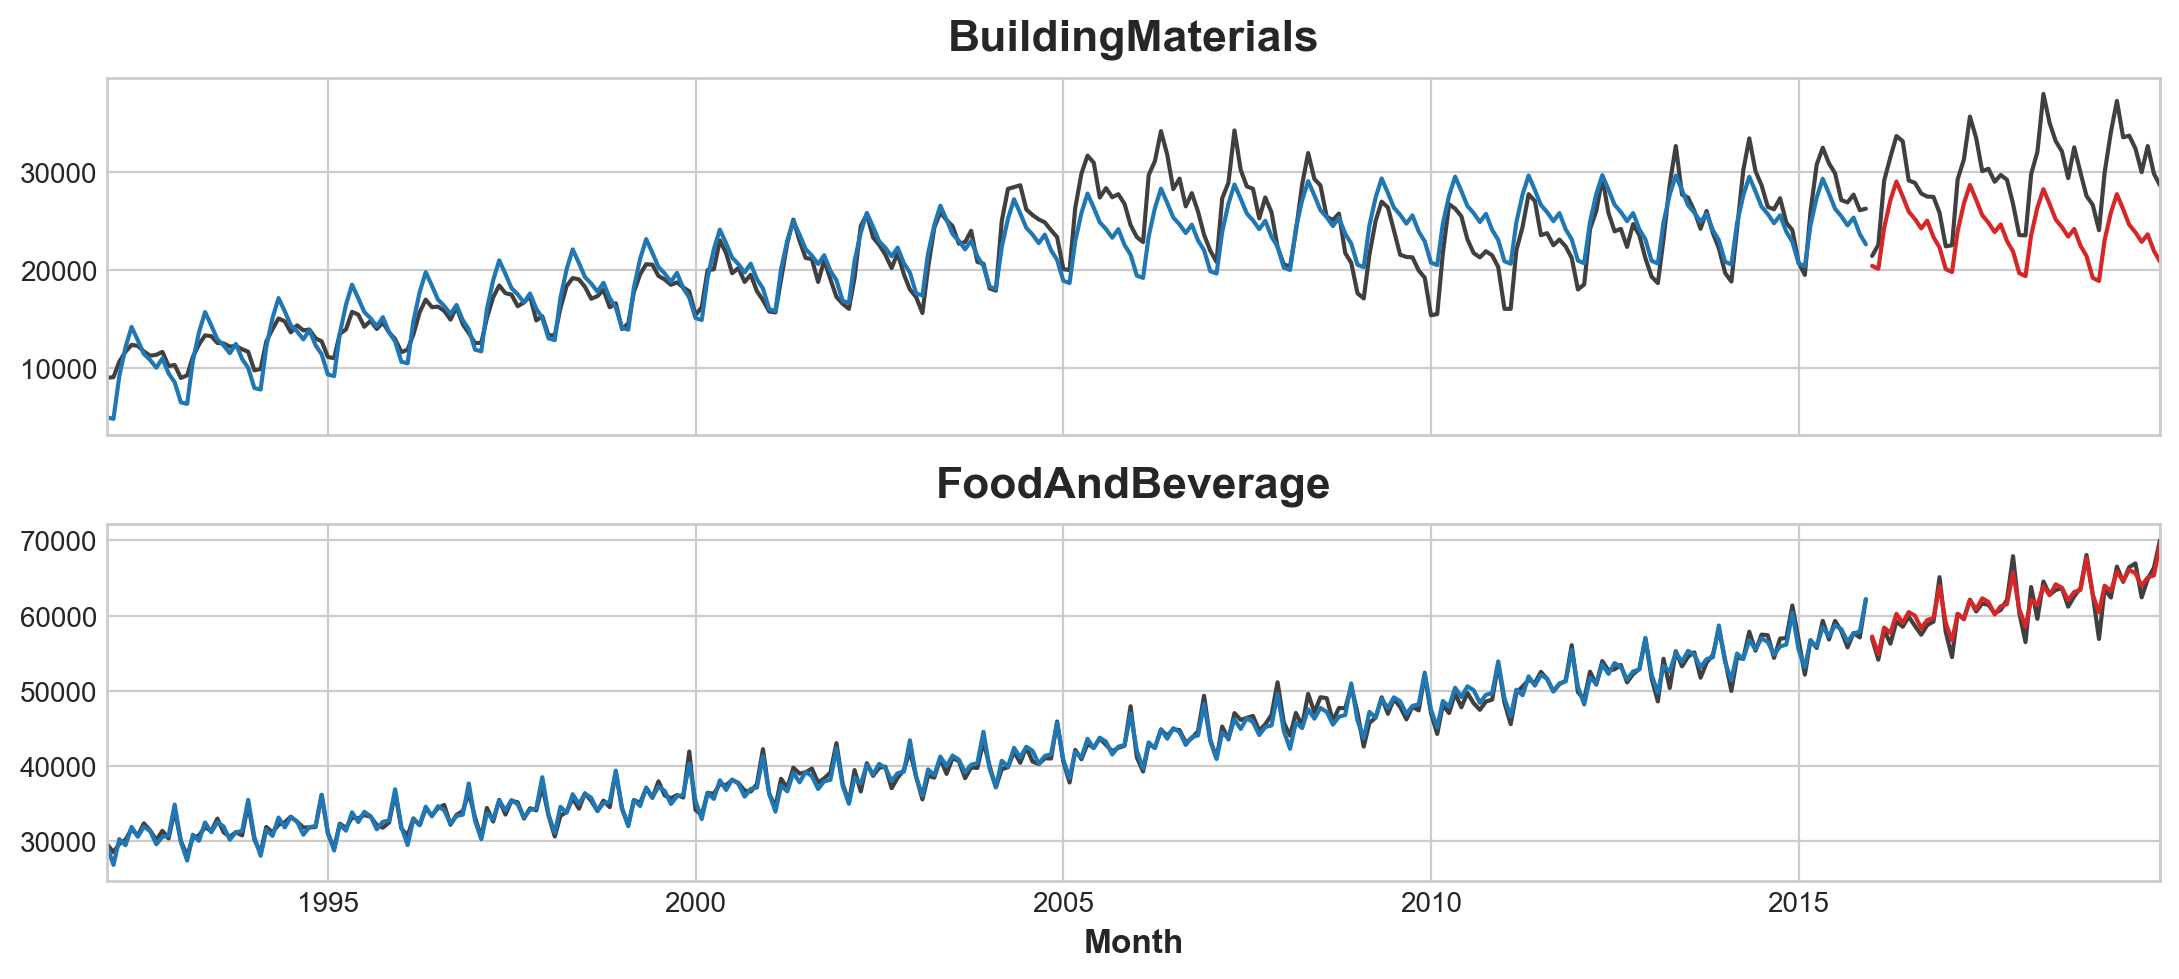

In [41]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

### Machine Learning

In [42]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

flu_trends = pd.read_csv("data/ts-course/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq = 'W'),
    inplace = True
)
flu_trends.drop("Week", axis=1, inplace=True)

In [43]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

y = flu_trends.FluVisits.copy() #setting this up any change to flu_trend will be copied
X = make_lags(y, lags=4).fillna(0.0)

In [44]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
y = make_multistep_target(y, steps=8).dropna()
y, X = y.align(X, join= "inner", axis = 0) # align make index of x and y homogenious

to read [more about align here](https://stackoverflow.com/questions/51645195/pandas-align-function-illustrative-example)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 389.12
Test RMSE: 582.33


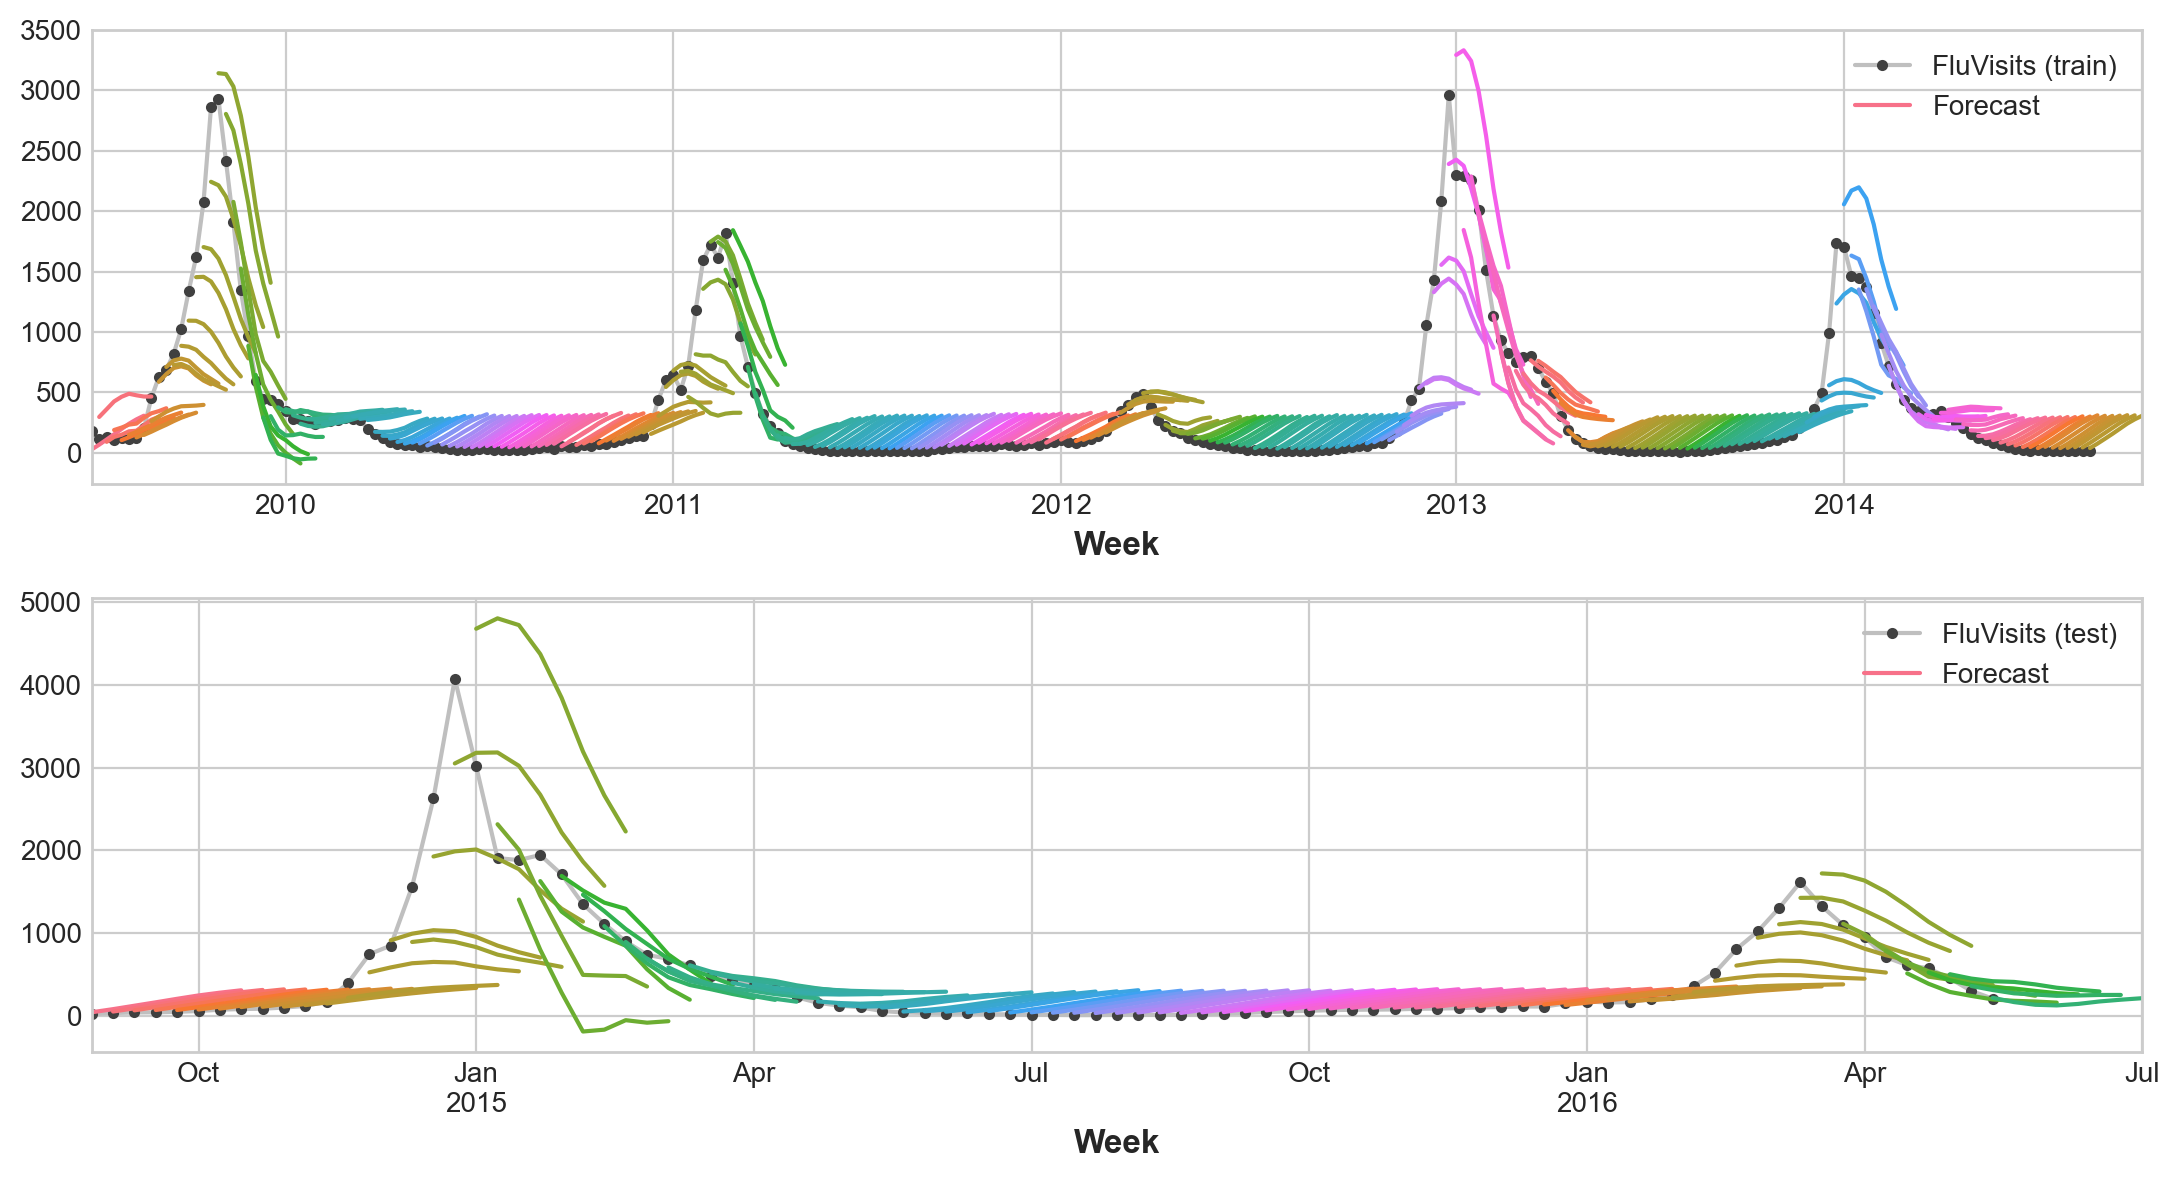

In [46]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

#### Direct Strategy - Use XGBoost regreesor

Here is short cut recursively produce mutli output regression model.
> XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's MultiOutputRegressor.

In [47]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor()) #cheat code
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [48]:
#X_train.sample(3)
y_train.sample(3)

y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  \
Week                                                                      
2013-07-08/2013-07-14        11      13.0      14.0      10.0      13.0   
2014-05-19/2014-05-25        80      61.0      47.0      33.0      27.0   
2012-12-24/2012-12-30      2961    2303.0    2291.0    2258.0    2012.0   

                       y_step_6  y_step_7  y_step_8  
Week                                                 
2013-07-08/2013-07-14      13.0      13.0      22.0  
2014-05-19/2014-05-25      19.0      22.0      19.0  
2012-12-24/2012-12-30    1510.0    1134.0     930.0

Train RMSE: 1.22
Test RMSE: 526.45


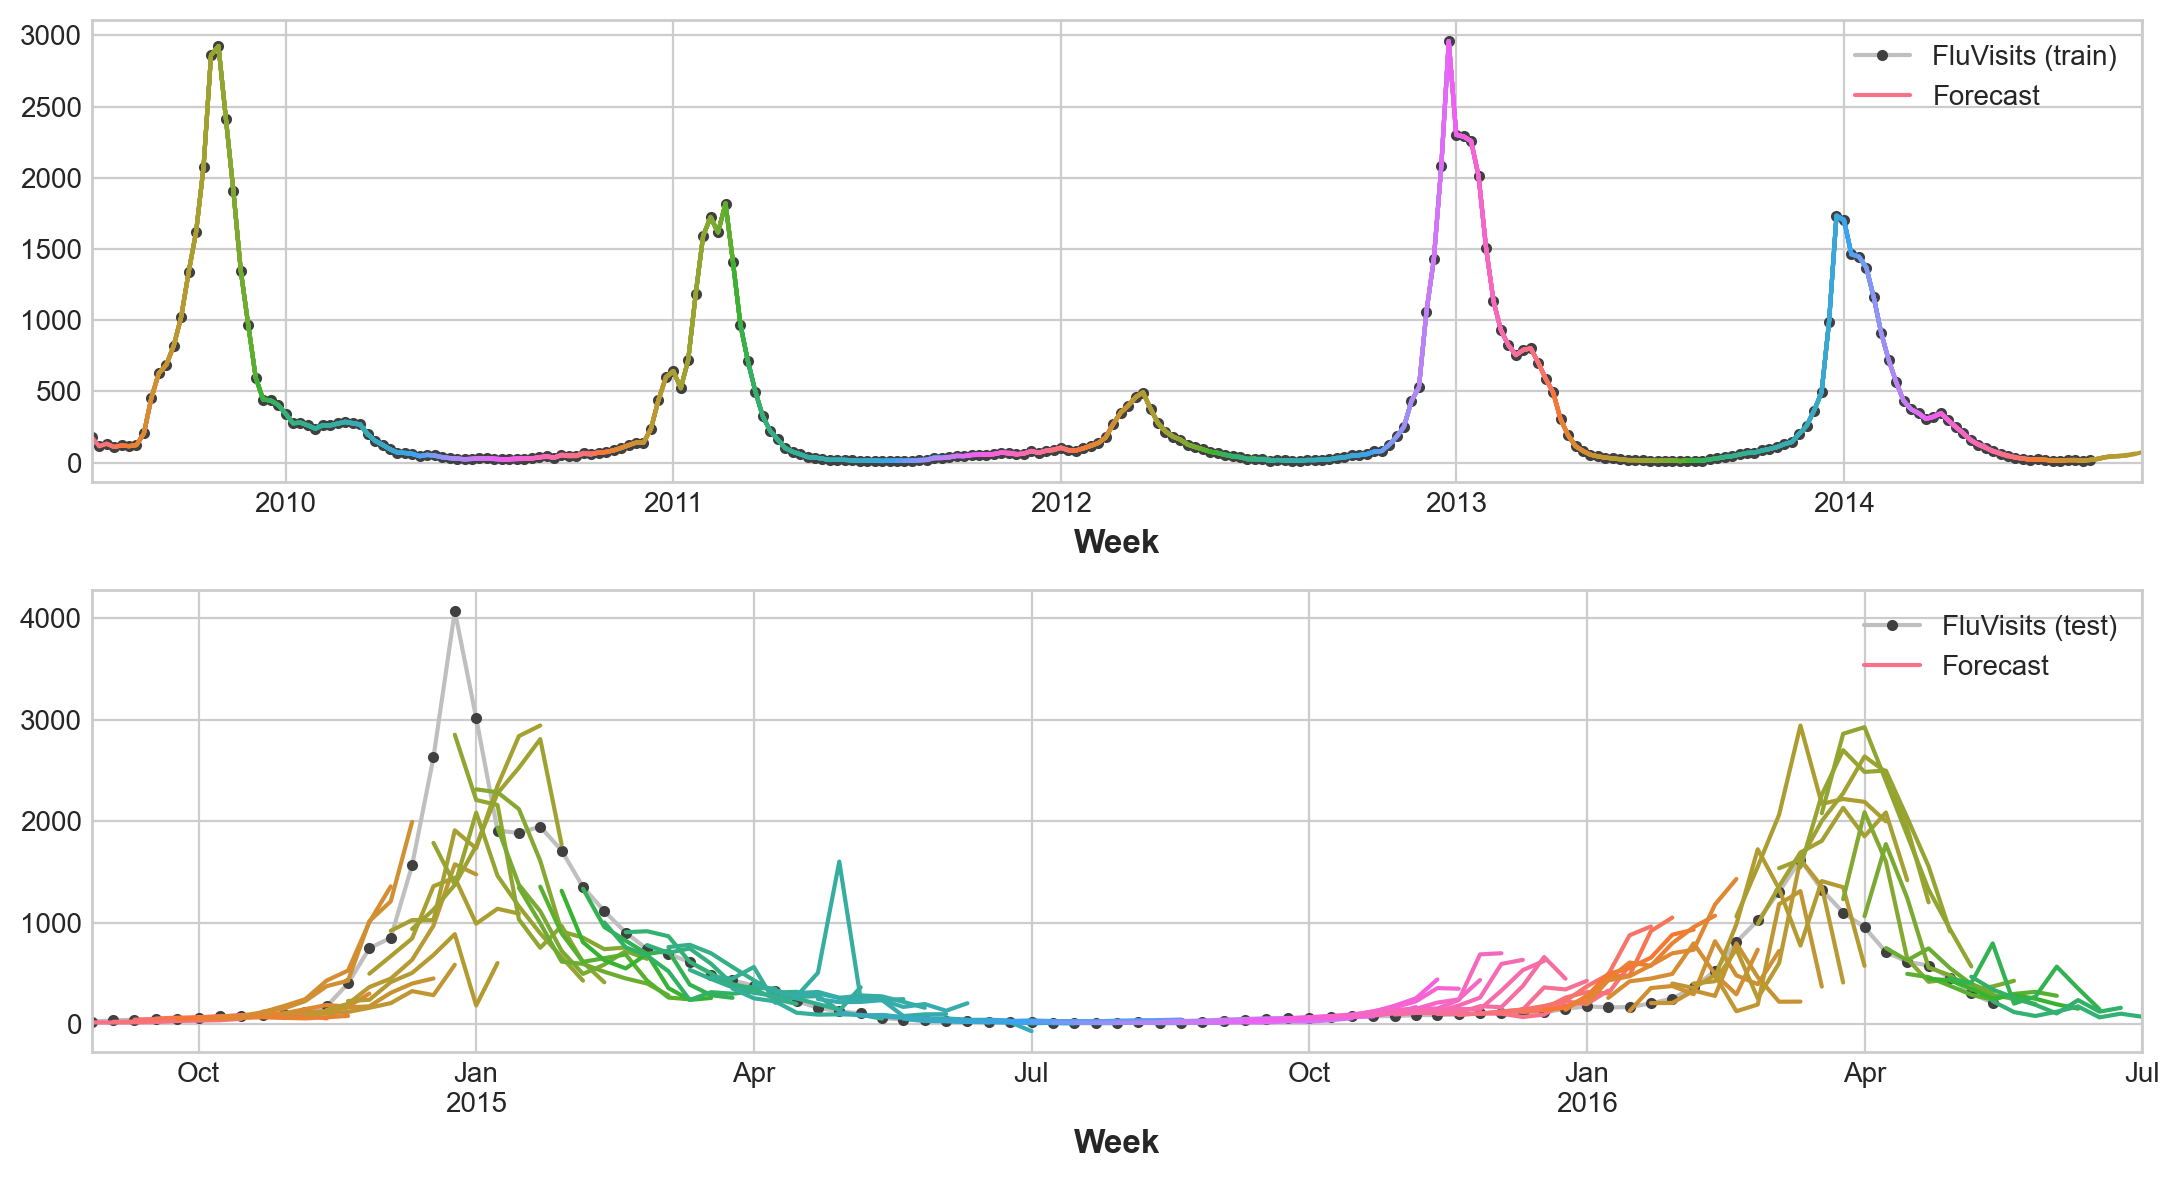

In [49]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

`RegressorChain()` versus `MultiOutputRegressor`